### imports

In [32]:
import re
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.append("../../")

from kernels import GaussianKernel, ReLUNTKKernel
from feature_decomp import Monomial
from tools import get_log_log_linear_fit
from utils import ensure_torch

In [36]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']

### plotting

In [ ]:
def plot_time_to_learn_eigenvalue(eigvals, timekeys, target_monomials, scale='log', **kwargs):
    print(type(target_monomials[0]))
    if type(target_monomials[0]) == str:
        target_monomials = np.array([Monomial.from_repr(target_monomial) for target_monomial in target_monomials])
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    #marker stuff
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    uniq_md     = np.unique(max_degrees)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False) is not False:
            plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
        else:
            plt.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=md2marker[md], color=colors[degree%7], alpha=kwargs.get("alpha", 1))
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel(f"FRA Eigval $\\lambda^{{-1}}$")
    plt.ylabel(f"Time to learn "+kwargs.get("breakpoint", ""))
    plt.title(f"Time to learn vs FRA Eigval")

In [ ]:
def _to_tuple(x):
    if x is None: return None
    return tuple(x) if isinstance(x, (list, tuple)) else (x,)

def nanvar(x: torch.Tensor, axis=None, correction: int = 1, keepdim: bool = False):
    if not torch.is_floating_point(x):
        x = x.float()
    dims = _to_tuple(axis)
    mask = ~torch.isnan(x)

    if dims is None:
        cnt = mask.sum()
        if cnt == 0 or (cnt - correction) <= 0:
            return torch.tensor(float('nan'), dtype=x.dtype, device=x.device)
        s = torch.where(mask, x, torch.zeros_like(x)).sum()
        m = s / cnt
        sq = torch.where(mask, (x - m) ** 2, torch.zeros_like(x)).sum()
        return sq / (cnt - correction)

    # reduce over multiple dims at once
    cnt = mask.sum(dim=dims, keepdim=True)
    s   = torch.where(mask, x, torch.zeros_like(x)).sum(dim=dims, keepdim=True)
    m   = s / cnt.clamp(min=1)
    sq  = torch.where(mask, (x - m) ** 2, torch.zeros_like(x)).sum(dim=dims, keepdim=True)

    dof = (cnt - correction).clamp(min=0)
    out = sq / dof.clamp(min=1)
    out = torch.where(dof > 0, out, torch.full_like(out, float('nan')))

    if keepdim:
        return out
    # squeeze all reduced dims
    for d in sorted(dims, reverse=True):
        out = out.squeeze(d)
    return out

def nanstd(x: torch.Tensor, dim=None, correction: int = 1, keepdim: bool = False):
    return nanvar(x, dim=dim, correction=correction, keepdim=keepdim).sqrt()


### text

In [2]:
text = """Working in directory /mnt/xdata/experiments/phlab/mlp-learning-order/synthetic/MLPtraining-gamma:1-target:monomial.

Generating monomials:   0%|          | 1/40000 [00:00<?, ?step/s]
Generating monomials:   7%|▋         | 2605/40000 [00:00<00:01, 26036.61step/s]
Generating monomials:  13%|█▎        | 5209/40000 [00:00<00:01, 21000.80step/s]
Generating monomials:  18%|█▊        | 7370/40000 [00:00<00:01, 18753.63step/s]
Generating monomials:  23%|██▎       | 9287/40000 [00:00<00:01, 17811.05step/s]
Generating monomials:  28%|██▊       | 11088/40000 [00:00<00:01, 17318.25step/s]
Generating monomials:  32%|███▏      | 12829/40000 [00:00<00:01, 16916.11step/s]
Generating monomials:  36%|███▋      | 14524/40000 [00:00<00:01, 16632.93step/s]
Generating monomials:  40%|████      | 16188/40000 [00:00<00:01, 16414.63step/s]
Generating monomials:  45%|████▍     | 17841/40000 [00:01<00:01, 16446.21step/s]
Generating monomials:  49%|████▊     | 19486/40000 [00:01<00:01, 15560.19step/s]
Generating monomials:  53%|█████▎    | 21097/40000 [00:01<00:01, 15715.00step/s]
Generating monomials:  57%|█████▋    | 22686/40000 [00:01<00:01, 15764.94step/s]
Generating monomials:  61%|██████    | 24294/40000 [00:01<00:00, 15855.35step/s]
Generating monomials:  65%|██████▍   | 25883/40000 [00:01<00:00, 15700.72step/s]
Generating monomials:  69%|██████▊   | 27456/40000 [00:01<00:00, 15181.03step/s]
Generating monomials:  72%|███████▏  | 28979/40000 [00:01<00:00, 14698.55step/s]
Generating monomials:  76%|███████▋  | 30565/40000 [00:01<00:00, 15028.50step/s]
Generating monomials:  80%|████████  | 32139/40000 [00:01<00:00, 15233.65step/s]
Generating monomials:  84%|████████▍ | 33713/40000 [00:02<00:00, 15379.72step/s]
Generating monomials:  88%|████████▊ | 35282/40000 [00:02<00:00, 15469.03step/s]
Generating monomials:  92%|█████████▏| 36854/40000 [00:02<00:00, 15541.99step/s]
Generating monomials:  96%|█████████▌| 38461/40000 [00:02<00:00, 15696.57step/s]
Generating monomials: 100%|██████████| 40000/40000 [00:02<00:00, 16208.88step/s]

Runs:   0%|          | 0/2000 [00:00<?, ?it/s]
Runs:   0%|          | 1/2000 [00:22<12:34:37, 22.65s/it, train 0.289 | test 0.276 | timekey [182 198] | n=256 | target=$1$ | trial=1]
Runs:   0%|          | 2/2000 [00:23<5:19:07,  9.58s/it, train 0.291 | test 0.278 | timekey [180 196] | n=256 | target=$1$ | trial=0] 
Runs:   0%|          | 3/2000 [01:36<21:33:22, 38.86s/it, train 0.303 | test 0.309 | timekey [914 965] | n=256 | target=$x_{0}$ | trial=0]
Runs:   0%|          | 4/2000 [01:37<13:09:38, 23.74s/it, train 0.286 | test 0.281 | timekey [919 970] | n=256 | target=$x_{0}$ | trial=1]
Runs:   0%|          | 5/2000 [01:42<9:26:05, 17.03s/it, train 0.322 | test 0.338 | timekey [1064 1115] | n=256 | target=$x_{1}$ | trial=0]
Runs:   0%|          | 6/2000 [01:44<6:41:32, 12.08s/it, train 0.342 | test 0.33 | timekey [1038 1104] | n=256 | target=$x_{1}$ | trial=1] 
Runs:   0%|          | 7/2000 [02:00<7:23:39, 13.36s/it, train 0.345 | test 0.327 | timekey [1182 1253] | n=256 | target=$x_{2}$ | trial=0]
Runs:   0%|          | 8/2000 [02:05<5:53:09, 10.64s/it, train 0.309 | test 0.317 | timekey [1189 1254] | n=256 | target=$x_{2}$ | trial=1]
Runs:   0%|          | 9/2000 [02:40<10:01:38, 18.13s/it, train 0.282 | test 0.273 | timekey [1319 1372] | n=256 | target=$x_{3}$ | trial=0]
Runs:   0%|          | 10/2000 [02:42<7:12:43, 13.05s/it, train 0.273 | test 0.272 | timekey [1334 1392] | n=256 | target=$x_{3}$ | trial=1]
Runs:   1%|          | 11/2000 [03:59<18:01:48, 32.63s/it, train 0.3 | test 0.306 | timekey [1420 1484] | n=256 | target=$x_{4}$ | trial=1] 
Runs:   1%|          | 12/2000 [04:03<13:17:26, 24.07s/it, train 0.352 | test 0.325 | timekey [1490 1572] | n=256 | target=$x_{5}$ | trial=0]
Runs:   1%|          | 13/2000 [04:04<9:20:25, 16.92s/it, train 0.263 | test 0.239 | timekey [1462 1515] | n=256 | target=$x_{4}$ | trial=0] 
Runs:   1%|          | 14/2000 [04:13<8:09:03, 14.78s/it, train 0.286 | test 0.274 | timekey [1545 1610] | n=256 | target=$x_{5}$ | trial=1]
Runs:   1%|          | 15/2000 [04:46<11:02:32, 20.03s/it, train 0.279 | test 0.271 | timekey [1683 1749] | n=256 | target=$x_{6}$ | trial=0]
Runs:   1%|          | 16/2000 [04:54<9:02:32, 16.41s/it, train 0.35 | test 0.384 | timekey [1623 1717] | n=256 | target=$x_{6}$ | trial=1]  
Runs:   1%|          | 17/2000 [05:40<14:00:54, 25.44s/it, train 0.333 | test 0.309 | timekey [1705 1791] | n=256 | target=$x_{7}$ | trial=0]
Runs:   1%|          | 18/2000 [05:43<10:21:49, 18.82s/it, train 0.284 | test 0.272 | timekey [1760 1825] | n=256 | target=$x_{7}$ | trial=1]
Runs:   1%|          | 19/2000 [06:54<18:53:36, 34.33s/it, train 0.235 | test 0.228 | timekey [1890 1945] | n=256 | target=$x_{8}$ | trial=1]
Runs:   1%|          | 20/2000 [06:58<13:48:53, 25.12s/it, train 0.315 | test 0.335 | timekey [1810 1891] | n=256 | target=$x_{8}$ | trial=0]
Runs:   1%|          | 21/2000 [07:15<12:29:49, 22.73s/it, train 0.333 | test 0.328 | timekey [1898 1982] | n=256 | target=$x_{9}$ | trial=0]
Runs:   1%|          | 22/2000 [07:20<9:34:46, 17.44s/it, train 0.282 | test 0.284 | timekey [1959 2021] | n=256 | target=$x_{9}$ | trial=1] 
Runs:   1%|          | 23/2000 [08:06<14:19:11, 26.08s/it, train 0.264 | test 0.243 | timekey [2066 2130] | n=256 | target=$x_{10}$ | trial=0]
Runs:   1%|          | 24/2000 [08:22<12:40:51, 23.10s/it, train 0.242 | test 0.237 | timekey [2060 2124] | n=256 | target=$x_{10}$ | trial=1]
Runs:   1%|▏         | 25/2000 [09:20<18:19:13, 33.39s/it, train 0.264 | test 0.249 | timekey [2114 2179] | n=256 | target=$x_{11}$ | trial=0]
Runs:   1%|▏         | 26/2000 [09:21<12:59:12, 23.68s/it, train 0.323 | test 0.315 | timekey [2074 2170] | n=256 | target=$x_{11}$ | trial=1]
Runs:   1%|▏         | 27/2000 [10:21<19:03:06, 34.76s/it, train 0.268 | test 0.26 | timekey [2233 2298] | n=256 | target=$x_{12}$ | trial=0] 
Runs:   1%|▏         | 28/2000 [10:34<15:30:36, 28.31s/it, train 0.287 | test 0.281 | timekey [2210 2288] | n=256 | target=$x_{12}$ | trial=1]
Runs:   1%|▏         | 29/2000 [10:55<14:16:25, 26.07s/it, train 0.275 | test 0.293 | timekey [2244 2320] | n=256 | target=$x_{13}$ | trial=1]
Runs:   2%|▏         | 30/2000 [10:57<10:12:14, 18.65s/it, train 0.293 | test 0.285 | timekey [2251 2333] | n=256 | target=$x_{13}$ | trial=0]
Runs:   2%|▏         | 31/2000 [11:51<15:59:19, 29.23s/it, train 0.275 | test 0.286 | timekey [2298 2379] | n=256 | target=$x_{14}$ | trial=0]
Runs:   2%|▏         | 32/2000 [12:16<15:19:56, 28.05s/it, train 0.308 | test 0.289 | timekey [2303 2385] | n=256 | target=$x_{14}$ | trial=1]
Runs:   2%|▏         | 33/2000 [13:25<22:08:20, 40.52s/it, train 0.345 | test 0.359 | timekey [2328 2420] | n=256 | target=$x_{15}$ | trial=0]
Runs:   2%|▏         | 34/2000 [13:32<16:31:08, 30.25s/it, train 0.286 | test 0.298 | timekey [2429 2502] | n=256 | target=$x_{15}$ | trial=1]
Runs:   2%|▏         | 35/2000 [14:08<17:34:03, 32.19s/it, train 0.351 | test 0.359 | timekey [2408 2502] | n=256 | target=$x_{16}$ | trial=0]
Runs:   2%|▏         | 36/2000 [14:40<17:23:11, 31.87s/it, train 0.301 | test 0.311 | timekey [2455 2536] | n=256 | target=$x_{16}$ | trial=1]
Runs:   2%|▏         | 37/2000 [15:05<16:15:42, 29.82s/it, train 0.266 | test 0.262 | timekey [2597 2671] | n=256 | target=$x_{17}$ | trial=0]
Runs:   2%|▏         | 38/2000 [15:14<12:58:20, 23.80s/it, train 0.235 | test 0.248 | timekey [2622 2686] | n=256 | target=$x_{17}$ | trial=1]
Runs:   2%|▏         | 39/2000 [16:15<18:55:26, 34.74s/it, train 0.266 | test 0.251 | timekey [2697 2778] | n=256 | target=$x_{18}$ | trial=0]
Runs:   2%|▏         | 40/2000 [16:51<19:06:08, 35.09s/it, train 0.246 | test 0.236 | timekey [2704 2777] | n=256 | target=$x_{18}$ | trial=1]
Runs:   2%|▏         | 41/2000 [18:17<27:29:29, 50.52s/it, train 0.297 | test 0.299 | timekey [2651 2734] | n=256 | target=$x_{20}$ | trial=0]
Runs:   2%|▏         | 42/2000 [18:19<19:32:19, 35.92s/it, train 0.283 | test 0.262 | timekey [2805 2888] | n=256 | target=$x_{19}$ | trial=0]
Runs:   2%|▏         | 43/2000 [18:25<14:40:46, 27.00s/it, train 0.275 | test 0.29 | timekey [2820 2916] | n=256 | target=$x_{19}$ | trial=1] 
Runs:   2%|▏         | 44/2000 [19:09<17:27:09, 32.12s/it, train 0.319 | test 0.291 | timekey [2682 2783] | n=256 | target=$x_{20}$ | trial=1]
Runs:   2%|▏         | 45/2000 [19:39<17:08:37, 31.57s/it, train 0.288 | test 0.28 | timekey [2848 2934] | n=256 | target=$x_{21}$ | trial=0] 
Runs:   2%|▏         | 46/2000 [19:51<13:55:21, 25.65s/it, train 0.309 | test 0.285 | timekey [2786 2879] | n=256 | target=$x_{21}$ | trial=1]
Runs:   2%|▏         | 47/2000 [21:01<21:06:02, 38.90s/it, train 0.27 | test 0.263 | timekey [2915 3004] | n=256 | target=$x_{22}$ | trial=0] 
Runs:   2%|▏         | 48/2000 [21:50<22:45:16, 41.97s/it, train 0.277 | test 0.282 | timekey [2945 3026] | n=256 | target=$x_{22}$ | trial=1]
Runs:   2%|▏         | 49/2000 [23:10<28:48:40, 53.16s/it, train 0.254 | test 0.237 | timekey [3160 3249] | n=256 | target=$x_{23}$ | trial=0]
Runs:   2%|▎         | 50/2000 [23:36<24:25:05, 45.08s/it, train 0.28 | test 0.294 | timekey [3030 3123] | n=256 | target=$x_{23}$ | trial=1] 
Runs:   3%|▎         | 51/2000 [23:36<17:09:13, 31.68s/it, train 0.292 | test 0.289 | timekey [2997 3088] | n=256 | target=$x_{24}$ | trial=0]
Runs:   3%|▎         | 52/2000 [24:03<16:23:19, 30.29s/it, train 0.314 | test 0.315 | timekey [2968 3067] | n=256 | target=$x_{24}$ | trial=1]
Runs:   3%|▎         | 53/2000 [24:43<17:52:51, 33.06s/it, train 0.264 | test 0.276 | timekey [3155 3244] | n=256 | target=$x_{25}$ | trial=0]
Runs:   3%|▎         | 54/2000 [24:55<14:32:29, 26.90s/it, train 0.326 | test 0.321 | timekey [3064 3169] | n=256 | target=$x_{25}$ | trial=1]
Runs:   3%|▎         | 55/2000 [26:16<23:11:23, 42.92s/it, train 0.288 | test 0.292 | timekey [3219 3315] | n=256 | target=$x_{26}$ | trial=0]
Runs:   3%|▎         | 56/2000 [27:19<26:30:25, 49.09s/it, train 0.266 | test 0.267 | timekey [3229 3320] | n=256 | target=$x_{26}$ | trial=1]
Runs:   3%|▎         | 57/2000 [28:07<26:19:24, 48.77s/it, train 0.264 | test 0.25 | timekey [3236 3329] | n=256 | target=$x_{27}$ | trial=0] 
Runs:   3%|▎         | 58/2000 [29:05<27:44:51, 51.44s/it, train 0.288 | test 0.284 | timekey [3161 3249] | n=256 | target=$x_{27}$ | trial=1]
Runs:   3%|▎         | 59/2000 [29:27<23:03:29, 42.77s/it, train 0.332 | test 0.323 | timekey [3339 3474] | n=256 | target=$x_{28}$ | trial=0]
Runs:   3%|▎         | 60/2000 [29:33<17:07:14, 31.77s/it, train 0.282 | test 0.291 | timekey [3373 3475] | n=256 | target=$x_{28}$ | trial=1]
Runs:   3%|▎         | 61/2000 [29:49<14:32:17, 26.99s/it, train 0.322 | test 0.304 | timekey [3205 3316] | n=256 | target=$x_{29}$ | trial=0]
Runs:   3%|▎         | 62/2000 [30:17<14:38:26, 27.20s/it, train 0.315 | test 0.291 | timekey [3245 3352] | n=256 | target=$x_{29}$ | trial=1]
Runs:   3%|▎         | 63/2000 [31:51<25:22:31, 47.16s/it, train 0.282 | test 0.26 | timekey [3429 3533] | n=256 | target=$x_{30}$ | trial=0] 
Runs:   3%|▎         | 64/2000 [33:11<30:41:28, 57.07s/it, train 0.282 | test 0.274 | timekey [3459 3564] | n=256 | target=$x_{30}$ | trial=1]
Runs:   3%|▎         | 65/2000 [33:35<25:20:48, 47.16s/it, train 0.223 | test 0.235 | timekey [3592 3675] | n=256 | target=$x_{31}$ | trial=0]
Runs:   3%|▎         | 66/2000 [35:11<33:15:28, 61.91s/it, train 0.297 | test 0.273 | timekey [3515 3628] | n=256 | target=$x_{31}$ | trial=1]
Runs:   3%|▎         | 67/2000 [35:14<23:40:29, 44.09s/it, train 0.311 | test 0.3 | timekey [3458 3574] | n=256 | target=$x_{32}$ | trial=1]  
Runs:   3%|▎         | 68/2000 [35:31<19:16:46, 35.92s/it, train 0.279 | test 0.271 | timekey [3591 3699] | n=256 | target=$x_{33}$ | trial=0]
Runs:   3%|▎         | 69/2000 [35:32<13:41:59, 25.54s/it, train 0.303 | test 0.304 | timekey [3514 3609] | n=256 | target=$x_{32}$ | trial=0]
Runs:   4%|▎         | 70/2000 [36:12<16:00:43, 29.87s/it, train 0.289 | test 0.275 | timekey [3591 3694] | n=256 | target=$x_{33}$ | trial=1]
Runs:   4%|▎         | 71/2000 [37:45<26:10:28, 48.85s/it, train 0.283 | test 0.28 | timekey [3620 3732] | n=256 | target=$x_{34}$ | trial=0] 
Runs:   4%|▎         | 72/2000 [39:16<32:56:51, 61.52s/it, train 0.309 | test 0.306 | timekey [3591 3708] | n=256 | target=$x_{34}$ | trial=1]
Runs:   4%|▎         | 73/2000 [39:25<24:25:19, 45.62s/it, train 0.276 | test 0.246 | timekey [3805 3922] | n=256 | target=$x_{35}$ | trial=0]
Runs:   4%|▎         | 74/2000 [41:11<34:08:37, 63.82s/it, train 0.276 | test 0.27 | timekey [3643 3730] | n=256 | target=$x_{36}$ | trial=1] 
Runs:   4%|▍         | 75/2000 [41:12<24:08:02, 45.13s/it, train 0.262 | test 0.238 | timekey [3727 3823] | n=256 | target=$x_{36}$ | trial=0]
Runs:   4%|▍         | 76/2000 [41:45<22:07:16, 41.39s/it, train 0.244 | test 0.223 | timekey [3811 3910] | n=256 | target=$x_{35}$ | trial=1]
Runs:   4%|▍         | 77/2000 [42:16<20:26:04, 38.26s/it, train 0.287 | test 0.282 | timekey [3894 4014] | n=256 | target=$x_{37}$ | trial=0]
Runs:   4%|▍         | 78/2000 [42:26<15:56:45, 29.87s/it, train 0.267 | test 0.257 | timekey [3834 3940] | n=256 | target=$x_{37}$ | trial=1]
Runs:   4%|▍         | 79/2000 [43:56<25:32:16, 47.86s/it, train 0.263 | test 0.271 | timekey [3861 3955] | n=256 | target=$x_{38}$ | trial=0]
Runs:   4%|▍         | 80/2000 [45:34<33:30:34, 62.83s/it, train 0.299 | test 0.28 | timekey [4033 4152] | n=256 | target=$x_{39}$ | trial=0] 
Runs:   4%|▍         | 81/2000 [45:50<25:56:59, 48.68s/it, train 0.303 | test 0.302 | timekey [3879 3996] | n=256 | target=$x_{38}$ | trial=1]
Runs:   4%|▍         | 82/2000 [47:30<34:08:02, 64.07s/it, train 0.281 | test 0.273 | timekey [3997 4111] | n=256 | target=$x_{39}$ | trial=1]
Runs:   4%|▍         | 83/2000 [47:34<24:37:13, 46.24s/it, train 0.31 | test 0.287 | timekey [3907 4039] | n=256 | target=$x_{40}$ | trial=0] 
Runs:   4%|▍         | 84/2000 [48:29<26:01:22, 48.90s/it, train 0.308 | test 0.32 | timekey [3894 4008] | n=256 | target=$x_{40}$ | trial=1]
Runs:   4%|▍         | 85/2000 [48:58<22:49:25, 42.91s/it, train 0.34 | test 0.363 | timekey [4001 4120] | n=256 | target=$x_{41}$ | trial=1]
Runs:   4%|▍         | 86/2000 [49:18<19:03:14, 35.84s/it, train 0.306 | test 0.321 | timekey [4059 4183] | n=256 | target=$x_{41}$ | trial=0]
Runs:   4%|▍         | 87/2000 [50:38<26:11:00, 49.27s/it, train 0.314 | test 0.322 | timekey [4120 4261] | n=256 | target=$x_{42}$ | trial=0]
Runs:   4%|▍         | 88/2000 [51:56<30:44:32, 57.88s/it, train 0.233 | test 0.231 | timekey [4194 4295] | n=256 | target=$x_{42}$ | trial=1]
Runs:   4%|▍         | 89/2000 [52:57<31:10:46, 58.74s/it, train 0.271 | test 0.285 | timekey [4203 4321] | n=256 | target=$x_{43}$ | trial=0]
Runs:   4%|▍         | 90/2000 [54:06<32:53:13, 61.99s/it, train 0.308 | test 0.303 | timekey [4180 4305] | n=256 | target=$x_{43}$ | trial=1]
Runs:   5%|▍         | 91/2000 [54:20<25:06:36, 47.35s/it, train 0.3 | test 0.316 | timekey [4171 4289] | n=256 | target=$x_{44}$ | trial=0]  
Runs:   5%|▍         | 92/2000 [55:37<29:53:43, 56.41s/it, train 0.317 | test 0.308 | timekey [4044 4178] | n=256 | target=$x_{45}$ | trial=0]
Runs:   5%|▍         | 93/2000 [55:44<22:01:48, 41.59s/it, train 0.267 | test 0.297 | timekey [4204 4313] | n=256 | target=$x_{44}$ | trial=1]
Runs:   5%|▍         | 94/2000 [56:20<21:08:57, 39.95s/it, train 0.328 | test 0.317 | timekey [4063 4186] | n=256 | target=$x_{45}$ | trial=1]
Runs:   5%|▍         | 95/2000 [57:19<24:09:06, 45.64s/it, train 0.243 | test 0.256 | timekey [4185 4284] | n=256 | target=$x_{46}$ | trial=0]
Runs:   5%|▍         | 96/2000 [58:16<25:49:31, 48.83s/it, train 0.314 | test 0.348 | timekey [4128 4245] | n=256 | target=$x_{46}$ | trial=1]
Runs:   5%|▍         | 97/2000 [1:00:18<37:27:35, 70.86s/it, train 0.284 | test 0.272 | timekey [4341 4465] | n=256 | target=$x_{47}$ | trial=0]
Runs:   5%|▍         | 98/2000 [1:01:03<33:23:57, 63.22s/it, train 0.295 | test 0.302 | timekey [4388 4512] | n=256 | target=$x_{47}$ | trial=1]
Runs:   5%|▍         | 99/2000 [1:01:29<27:27:39, 52.00s/it, train 0.28 | test 0.268 | timekey [4388 4510] | n=256 | target=$x_{48}$ | trial=0] 
Runs:   5%|▌         | 100/2000 [1:02:48<31:40:00, 60.00s/it, train 0.331 | test 0.361 | timekey [4343 4489] | n=256 | target=$x_{48}$ | trial=1]
Runs:   5%|▌         | 101/2000 [1:03:31<28:57:18, 54.89s/it, train 0.259 | test 0.288 | timekey [4514 4615] | n=256 | target=$x_{49}$ | trial=0]
Runs:   5%|▌         | 102/2000 [1:04:07<26:00:14, 49.32s/it, train 0.296 | test 0.296 | timekey [4477 4610] | n=256 | target=$x_{49}$ | trial=1]
Runs:   5%|▌         | 103/2000 [1:04:38<23:04:52, 43.80s/it, train 0.261 | test 0.238 | timekey [4588 4696] | n=256 | target=$x_{50}$ | trial=0]
Runs:   5%|▌         | 104/2000 [1:05:17<22:24:20, 42.54s/it, train 0.291 | test 0.292 | timekey [4543 4679] | n=256 | target=$x_{50}$ | trial=1]
Runs:   5%|▌         | 105/2000 [1:07:59<41:07:42, 78.13s/it, train 0.268 | test 0.267 | timekey [4527 4649] | n=256 | target=$x_{51}$ | trial=0]
Runs:   5%|▌         | 106/2000 [1:08:02<29:17:56, 55.69s/it, train 0.278 | test 0.242 | timekey [4547 4665] | n=256 | target=$x_{51}$ | trial=1]
Runs:   5%|▌         | 107/2000 [1:08:28<24:40:17, 46.92s/it, train 0.255 | test 0.248 | timekey [4690 4801] | n=256 | target=$x_{52}$ | trial=0]
Runs:   5%|▌         | 108/2000 [1:09:04<22:52:15, 43.52s/it, train 0.314 | test 0.308 | timekey [4581 4742] | n=256 | target=$x_{52}$ | trial=1]
Runs:   5%|▌         | 109/2000 [1:10:19<27:45:47, 52.85s/it, train 0.264 | test 0.262 | timekey [4647 4763] | n=256 | target=$x_{53}$ | trial=0]
Runs:   6%|▌         | 110/2000 [1:10:50<24:24:45, 46.50s/it, train 0.309 | test 0.289 | timekey [4619 4756] | n=256 | target=$x_{54}$ | trial=1]
Runs:   6%|▌         | 111/2000 [1:10:55<17:50:01, 33.99s/it, train 0.289 | test 0.28 | timekey [4652 4780] | n=256 | target=$x_{53}$ | trial=1] 
Runs:   6%|▌         | 112/2000 [1:10:57<12:46:05, 24.35s/it, train 0.304 | test 0.281 | timekey [4565 4699] | n=256 | target=$x_{54}$ | trial=0]
Runs:   6%|▌         | 113/2000 [1:13:32<33:19:13, 63.57s/it, train 0.32 | test 0.306 | timekey [4672 4817] | n=256 | target=$x_{55}$ | trial=1] 
Runs:   6%|▌         | 114/2000 [1:14:15<30:02:09, 57.33s/it, train 0.295 | test 0.303 | timekey [4745 4872] | n=256 | target=$x_{56}$ | trial=0]
Runs:   6%|▌         | 115/2000 [1:14:39<24:52:14, 47.50s/it, train 0.279 | test 0.292 | timekey [4696 4812] | n=256 | target=$x_{55}$ | trial=0]
Runs:   6%|▌         | 116/2000 [1:14:57<20:07:32, 38.46s/it, train 0.265 | test 0.245 | timekey [4818 4939] | n=256 | target=$x_{56}$ | trial=1]
Runs:   6%|▌         | 117/2000 [1:16:23<27:40:05, 52.90s/it, train 0.275 | test 0.289 | timekey [4778 4904] | n=256 | target=$x_{57}$ | trial=1]
Runs:   6%|▌         | 119/2000 [1:16:54<18:35:00, 35.57s/it, train 0.285 | test 0.286 | timekey [4947 5071] | n=256 | target=$x_{58}$ | trial=1]
Runs:   6%|▌         | 120/2000 [1:17:17<16:56:27, 32.44s/it, train 0.309 | test 0.316 | timekey [4955 5098] | n=256 | target=$x_{58}$ | trial=0]
Runs:   6%|▌         | 121/2000 [1:19:18<28:58:39, 55.52s/it, train 0.275 | test 0.282 | timekey [4912 5040] | n=256 | target=$x_{59}$ | trial=0]
Runs:   6%|▌         | 122/2000 [1:20:15<29:10:57, 55.94s/it, train 0.267 | test 0.28 | timekey [4944 5057] | n=256 | target=$x_{59}$ | trial=1] 
Runs:   6%|▌         | 123/2000 [1:20:55<26:56:19, 51.67s/it, train 0.255 | test 0.241 | timekey [4951 5064] | n=256 | target=$x_{60}$ | trial=1]
Runs:   6%|▌         | 124/2000 [1:20:58<19:34:27, 37.56s/it, train 0.278 | test 0.26 | timekey [4915 5055] | n=256 | target=$x_{60}$ | trial=0] 
Runs:   6%|▋         | 125/2000 [1:22:36<28:41:56, 55.10s/it, train 0.21 | test 0.195 | timekey [5371 5485] | n=256 | target=$x_{61}$ | trial=0]
Runs:   6%|▋         | 126/2000 [1:22:49<22:19:53, 42.90s/it, train 0.301 | test 0.308 | timekey [4907 5046] | n=256 | target=$x_{62}$ | trial=0]
Runs:   6%|▋         | 127/2000 [1:23:21<20:33:54, 39.53s/it, train 0.223 | test 0.213 | timekey [5354 5473] | n=256 | target=$x_{61}$ | trial=1]
Runs:   6%|▋         | 128/2000 [1:23:45<18:10:04, 34.94s/it, train 0.29 | test 0.297 | timekey [5036 5169] | n=256 | target=$x_{62}$ | trial=1] 
Runs:   6%|▋         | 129/2000 [1:25:31<29:12:38, 56.20s/it, train 0.247 | test 0.233 | timekey [5330 5444] | n=256 | target=$x_{63}$ | trial=0]
Runs:   6%|▋         | 130/2000 [1:26:33<30:06:46, 57.97s/it, train 0.265 | test 0.269 | timekey [5197 5323] | n=256 | target=$x_{63}$ | trial=1]
Runs:   7%|▋         | 131/2000 [1:27:09<26:37:46, 51.29s/it, train 0.262 | test 0.277 | timekey [5153 5274] | n=256 | target=$x_{64}$ | trial=0]
Runs:   7%|▋         | 132/2000 [1:27:33<22:24:17, 43.18s/it, train 0.27 | test 0.284 | timekey [5149 5274] | n=256 | target=$x_{64}$ | trial=1] 
Runs:   7%|▋         | 133/2000 [1:28:23<23:27:10, 45.22s/it, train 0.303 | test 0.299 | timekey [4978 5119] | n=256 | target=$x_{65}$ | trial=0]
Runs:   7%|▋         | 134/2000 [1:28:46<19:55:37, 38.44s/it, train 0.31 | test 0.314 | timekey [4929 5063] | n=256 | target=$x_{65}$ | trial=1] 
Runs:   7%|▋         | 135/2000 [1:29:54<24:30:19, 47.30s/it, train 0.281 | test 0.277 | timekey [5001 5127] | n=256 | target=$x_{66}$ | trial=0]
Runs:   7%|▋         | 136/2000 [1:30:13<20:11:00, 38.98s/it, train 0.296 | test 0.309 | timekey [5049 5184] | n=256 | target=$x_{66}$ | trial=1]
Runs:   7%|▋         | 137/2000 [1:31:40<27:35:47, 53.33s/it, train 0.287 | test 0.296 | timekey [5238 5377] | n=256 | target=$x_{67}$ | trial=0]
Runs:   7%|▋         | 138/2000 [1:33:00<31:44:53, 61.38s/it, train 0.295 | test 0.31 | timekey [5322 5450] | n=256 | target=$x_{67}$ | trial=1] 
Runs:   7%|▋         | 139/2000 [1:33:25<26:01:46, 50.35s/it, train 0.272 | test 0.247 | timekey [5179 5307] | n=256 | target=$x_{68}$ | trial=0]
Runs:   7%|▋         | 140/2000 [1:34:22<27:06:11, 52.46s/it, train 0.273 | test 0.284 | timekey [5317 5458] | n=256 | target=$x_{68}$ | trial=1]
Runs:   7%|▋         | 141/2000 [1:34:34<20:46:43, 40.24s/it, train 0.293 | test 0.314 | timekey [5323 5472] | n=256 | target=$x_{69}$ | trial=0]
Runs:   7%|▋         | 142/2000 [1:35:13<20:36:00, 39.91s/it, train 0.268 | test 0.264 | timekey [5391 5504] | n=256 | target=$x_{69}$ | trial=1]
Runs:   7%|▋         | 143/2000 [1:37:08<32:13:49, 62.48s/it, train 0.256 | test 0.252 | timekey [5516 5659] | n=256 | target=$x_{70}$ | trial=0]
Runs:   7%|▋         | 144/2000 [1:37:26<25:13:58, 48.94s/it, train 0.288 | test 0.277 | timekey [5620 5777] | n=256 | target=$x_{70}$ | trial=1]
Runs:   7%|▋         | 145/2000 [1:37:43<20:25:06, 39.63s/it, train 0.274 | test 0.268 | timekey [5168 5287] | n=256 | target=$x_{71}$ | trial=0]
Runs:   7%|▋         | 146/2000 [1:39:16<28:38:21, 55.61s/it, train 0.293 | test 0.287 | timekey [5162 5298] | n=256 | target=$x_{71}$ | trial=1]
Runs:   7%|▋         | 147/2000 [1:39:56<26:04:55, 50.67s/it, train 0.25 | test 0.24 | timekey [5388 5516] | n=256 | target=$x_{72}$ | trial=0]  
Runs:   7%|▋         | 148/2000 [1:40:45<25:48:54, 50.18s/it, train 0.281 | test 0.278 | timekey [5334 5469] | n=256 | target=$x_{73}$ | trial=0]
Runs:   7%|▋         | 149/2000 [1:41:10<21:56:23, 42.67s/it, train 0.293 | test 0.298 | timekey [5308 5447] | n=256 | target=$x_{72}$ | trial=1]
Runs:   8%|▊         | 150/2000 [1:41:38<19:45:58, 38.46s/it, train 0.273 | test 0.266 | timekey [5344 5473] | n=256 | target=$x_{73}$ | trial=1]
Runs:   8%|▊         | 151/2000 [1:44:18<38:26:23, 74.84s/it, train 0.294 | test 0.291 | timekey [5455 5604] | n=256 | target=$x_{74}$ | trial=0]
Runs:   8%|▊         | 152/2000 [1:44:23<27:43:16, 54.00s/it, train 0.273 | test 0.298 | timekey [5666 5818] | n=256 | target=$x_{75}$ | trial=0]
Runs:   8%|▊         | 153/2000 [1:44:39<21:44:07, 42.36s/it, train 0.258 | test 0.265 | timekey [5660 5780] | n=256 | target=$x_{74}$ | trial=1]
Runs:   8%|▊         | 154/2000 [1:46:05<28:32:50, 55.67s/it, train 0.289 | test 0.297 | timekey [5636 5769] | n=256 | target=$x_{75}$ | trial=1]
Runs:   8%|▊         | 155/2000 [1:46:36<24:37:30, 48.05s/it, train 0.256 | test 0.24 | timekey [5520 5649] | n=256 | target=$x_{76}$ | trial=0] 
Runs:   8%|▊         | 156/2000 [1:47:10<22:30:10, 43.93s/it, train 0.268 | test 0.253 | timekey [5533 5683] | n=256 | target=$x_{76}$ | trial=1]
Runs:   8%|▊         | 157/2000 [1:48:31<28:09:36, 55.01s/it, train 0.32 | test 0.322 | timekey [5688 5859] | n=256 | target=$x_{77}$ | trial=1] 
Runs:   8%|▊         | 158/2000 [1:48:33<19:58:57, 39.05s/it, train 0.244 | test 0.263 | timekey [5773 5893] | n=256 | target=$x_{77}$ | trial=0]
Runs:   8%|▊         | 159/2000 [1:51:19<39:31:26, 77.29s/it, train 0.259 | test 0.254 | timekey [5899 6054] | n=256 | target=$x_{78}$ | trial=1]
Runs:   8%|▊         | 160/2000 [1:51:58<33:36:57, 65.77s/it, train 0.265 | test 0.244 | timekey [5852 5997] | n=256 | target=$x_{78}$ | trial=0]
Runs:   8%|▊         | 161/2000 [1:52:11<25:31:22, 49.96s/it, train 0.248 | test 0.258 | timekey [5907 6046] | n=256 | target=$x_{79}$ | trial=0]
Runs:   8%|▊         | 162/2000 [1:53:08<26:37:05, 52.14s/it, train 0.252 | test 0.238 | timekey [5834 5965] | n=256 | target=$x_{79}$ | trial=1]
Runs:   8%|▊         | 163/2000 [1:53:45<24:14:16, 47.50s/it, train 0.256 | test 0.243 | timekey [5892 6042] | n=256 | target=$x_{80}$ | trial=0]
Runs:   8%|▊         | 164/2000 [1:53:56<18:40:42, 36.62s/it, train 0.257 | test 0.255 | timekey [5850 5992] | n=256 | target=$x_{80}$ | trial=1]
Runs:   8%|▊         | 165/2000 [1:55:27<26:54:01, 52.77s/it, train 0.266 | test 0.267 | timekey [5753 5908] | n=256 | target=$x_{81}$ | trial=0]
Runs:   8%|▊         | 166/2000 [1:55:54<22:55:52, 45.01s/it, train 0.265 | test 0.267 | timekey [5697 5831] | n=256 | target=$x_{81}$ | trial=1]
Runs:   8%|▊         | 167/2000 [1:58:04<35:53:01, 70.48s/it, train 0.263 | test 0.265 | timekey [5755 5882] | n=256 | target=$x_{82}$ | trial=0]
Runs:   8%|▊         | 168/2000 [1:59:27<37:47:05, 74.25s/it, train 0.307 | test 0.335 | timekey [5687 5849] | n=256 | target=$x_{82}$ | trial=1]
Runs:   8%|▊         | 169/2000 [1:59:37<27:59:09, 55.02s/it, train 0.282 | test 0.296 | timekey [5801 5955] | n=256 | target=$x_{83}$ | trial=0]
Runs:   8%|▊         | 170/2000 [2:00:13<25:03:59, 49.31s/it, train 0.308 | test 0.303 | timekey [5807 5981] | n=256 | target=$x_{83}$ | trial=1]
Runs:   9%|▊         | 171/2000 [2:00:56<24:11:18, 47.61s/it, train 0.297 | test 0.276 | timekey [6031 6195] | n=256 | target=$x_{84}$ | trial=1]
Runs:   9%|▊         | 172/2000 [2:01:03<17:55:45, 35.31s/it, train 0.265 | test 0.254 | timekey [6016 6159] | n=256 | target=$x_{84}$ | trial=0]
Runs:   9%|▊         | 173/2000 [2:02:58<30:06:02, 59.31s/it, train 0.246 | test 0.228 | timekey [6252 6394] | n=256 | target=$x_{85}$ | trial=0]
Runs:   9%|▊         | 174/2000 [2:03:49<28:51:05, 56.88s/it, train 0.253 | test 0.24 | timekey [6136 6291] | n=256 | target=$x_{85}$ | trial=1] 
Runs:   9%|▉         | 175/2000 [2:05:07<31:54:30, 62.94s/it, train 0.277 | test 0.265 | timekey [5990 6151] | n=256 | target=$x_{86}$ | trial=0]
Runs:   9%|▉         | 176/2000 [2:07:06<40:28:46, 79.89s/it, train 0.31 | test 0.333 | timekey [5846 6001] | n=256 | target=$x_{87}$ | trial=0] 
Runs:   9%|▉         | 177/2000 [2:07:21<30:39:44, 60.55s/it, train 0.271 | test 0.273 | timekey [6009 6152] | n=256 | target=$x_{86}$ | trial=1]
Runs:   9%|▉         | 178/2000 [2:07:22<21:32:21, 42.56s/it, train 0.224 | test 0.234 | timekey [5950 6059] | n=256 | target=$x_{87}$ | trial=1]
Runs:   9%|▉         | 179/2000 [2:08:03<21:20:53, 42.20s/it, train 0.29 | test 0.28 | timekey [6145 6299] | n=256 | target=$x_{88}$ | trial=0]  
Runs:   9%|▉         | 180/2000 [2:08:30<19:01:30, 37.63s/it, train 0.253 | test 0.244 | timekey [6153 6286] | n=256 | target=$x_{88}$ | trial=1]
Runs:   9%|▉         | 181/2000 [2:10:36<32:22:35, 64.08s/it, train 0.254 | test 0.219 | timekey [6277 6421] | n=256 | target=$x_{89}$ | trial=0]
Runs:   9%|▉         | 182/2000 [2:11:52<34:08:52, 67.62s/it, train 0.275 | test 0.261 | timekey [6222 6381] | n=256 | target=$x_{89}$ | trial=1]
Runs:   9%|▉         | 183/2000 [2:11:59<24:55:36, 49.39s/it, train 0.324 | test 0.319 | timekey [5912 6108] | n=256 | target=$x_{90}$ | trial=0]
Runs:   9%|▉         | 184/2000 [2:14:40<41:45:07, 82.77s/it, train 0.28 | test 0.269 | timekey [6034 6180] | n=256 | target=$x_{91}$ | trial=1] 
Runs:   9%|▉         | 185/2000 [2:14:53<31:11:56, 61.88s/it, train 0.258 | test 0.279 | timekey [6151 6296] | n=256 | target=$x_{90}$ | trial=1]
Runs:   9%|▉         | 186/2000 [2:15:11<24:31:55, 48.69s/it, train 0.303 | test 0.288 | timekey [5920 6091] | n=256 | target=$x_{91}$ | trial=0]
Runs:   9%|▉         | 187/2000 [2:15:11<17:10:43, 34.11s/it, train 0.29 | test 0.303 | timekey [6137 6300] | n=256 | target=$x_{92}$ | trial=0] 
Runs:   9%|▉         | 188/2000 [2:15:54<18:32:57, 36.85s/it, train 0.315 | test 0.351 | timekey [6083 6241] | n=256 | target=$x_{92}$ | trial=1]
Runs:   9%|▉         | 189/2000 [2:18:12<33:48:44, 67.21s/it, train 0.288 | test 0.285 | timekey [6230 6396] | n=256 | target=$x_{93}$ | trial=0]
Runs:  10%|▉         | 190/2000 [2:19:16<33:19:50, 66.29s/it, train 0.223 | test 0.218 | timekey [6399 6523] | n=256 | target=$x_{94}$ | trial=0]
Runs:  10%|▉         | 191/2000 [2:19:53<28:55:04, 57.55s/it, train 0.275 | test 0.28 | timekey [6189 6358] | n=256 | target=$x_{93}$ | trial=1] 
Runs:  10%|▉         | 192/2000 [2:22:16<41:43:18, 83.07s/it, train 0.254 | test 0.253 | timekey [6302 6449] | n=256 | target=$x_{94}$ | trial=1]
Runs:  10%|▉         | 193/2000 [2:22:18<29:31:15, 58.81s/it, train 0.246 | test 0.255 | timekey [6177 6314] | n=256 | target=$x_{96}$ | trial=0]
Runs:  10%|▉         | 194/2000 [2:22:49<25:16:16, 50.37s/it, train 0.313 | test 0.306 | timekey [6354 6555] | n=256 | target=$x_{95}$ | trial=0]
Runs:  10%|▉         | 195/2000 [2:23:22<22:37:05, 45.11s/it, train 0.283 | test 0.264 | timekey [6145 6296] | n=256 | target=$x_{96}$ | trial=1]
Runs:  10%|▉         | 196/2000 [2:23:27<16:36:06, 33.13s/it, train 0.311 | test 0.314 | timekey [6268 6436] | n=256 | target=$x_{95}$ | trial=1]
Runs:  10%|▉         | 197/2000 [2:26:15<36:53:43, 73.67s/it, train 0.236 | test 0.242 | timekey [6622 6776] | n=256 | target=$x_{97}$ | trial=0]
Runs:  10%|▉         | 198/2000 [2:26:34<28:36:21, 57.15s/it, train 0.444 | test 0.439 | timekey [3516 3761] | n=256 | target=$x_{0}^2$ | trial=0]
Runs:  10%|▉         | 199/2000 [2:26:43<21:22:50, 42.74s/it, train 0.263 | test 0.268 | timekey [6486 6663] | n=256 | target=$x_{97}$ | trial=1] 
Runs:  10%|█         | 200/2000 [2:27:28<21:48:11, 43.61s/it, train 0.339 | test 0.253 | timekey [3683 3839] | n=256 | target=$x_{0}^2$ | trial=1]
Runs:  10%|█         | 201/2000 [2:28:10<21:31:52, 43.09s/it, train 0.296 | test 0.295 | timekey [6410 6569] | n=256 | target=$x_{98}$ | trial=0] 
Runs:  10%|█         | 202/2000 [2:30:00<31:26:34, 62.96s/it, train 0.22 | test 0.221 | timekey [6421 6543] | n=256 | target=$x_{98}$ | trial=1] 
Runs:  10%|█         | 203/2000 [2:31:10<32:28:02, 65.04s/it, train 0.234 | test 0.235 | timekey [6556 6699] | n=256 | target=$x_{99}$ | trial=0]
Runs:  10%|█         | 204/2000 [2:32:01<30:21:59, 60.87s/it, train 0.267 | test 0.242 | timekey [6489 6670] | n=256 | target=$x_{99}$ | trial=1]
Runs:  10%|█         | 205/2000 [2:34:03<39:29:02, 79.19s/it, train 0.286 | test 0.345 | timekey [6395 6567] | n=256 | target=$x_{101}$ | trial=0]
Runs:  10%|█         | 206/2000 [2:34:03<27:45:33, 55.70s/it, train 0.293 | test 0.287 | timekey [6392 6570] | n=256 | target=$x_{100}$ | trial=0]
Runs:  10%|█         | 207/2000 [2:34:11<20:35:18, 41.34s/it, train 0.211 | test 0.202 | timekey [6644 6760] | n=256 | target=$x_{100}$ | trial=1]
Runs:  10%|█         | 208/2000 [2:35:37<27:08:52, 54.54s/it, train 0.25 | test 0.234 | timekey [6570 6719] | n=256 | target=$x_{101}$ | trial=1] 
Runs:  10%|█         | 209/2000 [2:36:31<27:02:25, 54.35s/it, train 0.278 | test 0.267 | timekey [6664 6827] | n=256 | target=$x_{102}$ | trial=0]
Runs:  10%|█         | 210/2000 [2:38:11<33:55:45, 68.24s/it, train 0.23 | test 0.206 | timekey [6782 6932] | n=256 | target=$x_{102}$ | trial=1] 
Runs:  11%|█         | 211/2000 [2:39:00<31:04:33, 62.53s/it, train 0.26 | test 0.261 | timekey [6608 6760] | n=256 | target=$x_{103}$ | trial=0]
Runs:  11%|█         | 212/2000 [2:40:40<36:34:49, 73.65s/it, train 0.299 | test 0.266 | timekey [6546 6729] | n=256 | target=$x_{103}$ | trial=1]
Runs:  11%|█         | 213/2000 [2:41:35<33:50:27, 68.17s/it, train 0.276 | test 0.292 | timekey [6588 6753] | n=256 | target=$x_{104}$ | trial=0]
Runs:  11%|█         | 214/2000 [2:41:48<25:36:32, 51.62s/it, train 0.267 | test 0.248 | timekey [6652 6824] | n=256 | target=$x_{105}$ | trial=0]
Runs:  11%|█         | 215/2000 [2:42:10<21:07:30, 42.61s/it, train 0.247 | test 0.242 | timekey [6678 6823] | n=256 | target=$x_{104}$ | trial=1]
Runs:  11%|█         | 216/2000 [2:43:46<28:59:37, 58.51s/it, train 0.271 | test 0.252 | timekey [6564 6723] | n=256 | target=$x_{105}$ | trial=1]
Runs:  11%|█         | 217/2000 [2:45:20<34:19:12, 69.29s/it, train 0.304 | test 0.268 | timekey [7036 7238] | n=256 | target=$x_{106}$ | trial=0]
Runs:  11%|█         | 218/2000 [2:46:44<36:27:25, 73.65s/it, train 0.247 | test 0.263 | timekey [7068 7223] | n=256 | target=$x_{106}$ | trial=1]
Runs:  11%|█         | 219/2000 [2:47:04<28:25:16, 57.45s/it, train 0.261 | test 0.264 | timekey [6794 6937] | n=256 | target=$x_{107}$ | trial=0]
Runs:  11%|█         | 220/2000 [2:49:33<42:06:53, 85.18s/it, train 0.278 | test 0.296 | timekey [6955 7125] | n=256 | target=$x_{108}$ | trial=0]
Runs:  11%|█         | 221/2000 [2:49:35<29:39:13, 60.01s/it, train 0.274 | test 0.259 | timekey [6762 6927] | n=256 | target=$x_{107}$ | trial=1]
Runs:  11%|█         | 222/2000 [2:49:36<20:58:06, 42.46s/it, train 0.275 | test 0.277 | timekey [6951 7126] | n=256 | target=$x_{108}$ | trial=1]
Runs:  11%|█         | 223/2000 [2:50:19<20:59:42, 42.53s/it, train 0.314 | test 0.323 | timekey [6756 6957] | n=256 | target=$x_{109}$ | trial=0]
Runs:  11%|█         | 224/2000 [2:52:10<31:06:52, 63.07s/it, train 0.271 | test 0.265 | timekey [6769 6939] | n=256 | target=$x_{109}$ | trial=1]
Runs:  11%|█▏        | 225/2000 [2:54:09<39:22:45, 79.87s/it, train 0.264 | test 0.305 | timekey [7079 7239] | n=256 | target=$x_{110}$ | trial=0]
Runs:  11%|█▏        | 226/2000 [2:55:15<37:18:53, 75.72s/it, train 0.292 | test 0.282 | timekey [7061 7251] | n=256 | target=$x_{110}$ | trial=1]
Runs:  11%|█▏        | 227/2000 [2:55:27<27:54:28, 56.67s/it, train 0.247 | test 0.242 | timekey [7063 7225] | n=256 | target=$x_{111}$ | trial=0]
Runs:  11%|█▏        | 228/2000 [2:57:29<37:32:53, 76.28s/it, train 0.261 | test 0.241 | timekey [7023 7196] | n=256 | target=$x_{112}$ | trial=1]
Runs:  11%|█▏        | 229/2000 [2:57:41<27:56:03, 56.78s/it, train 0.312 | test 0.316 | timekey [7066 7257] | n=256 | target=$x_{111}$ | trial=1]
Runs:  12%|█▏        | 230/2000 [2:58:26<26:12:12, 53.30s/it, train 0.251 | test 0.256 | timekey [6846 6998] | n=256 | target=$x_{113}$ | trial=0]
Runs:  12%|█▏        | 231/2000 [2:58:30<18:56:21, 38.54s/it, train 0.232 | test 0.233 | timekey [7014 7158] | n=256 | target=$x_{112}$ | trial=0]
Runs:  12%|█▏        | 232/2000 [3:00:45<33:08:35, 67.49s/it, train 0.297 | test 0.309 | timekey [6889 7076] | n=256 | target=$x_{113}$ | trial=1]
Runs:  12%|█▏        | 233/2000 [3:03:15<45:15:18, 92.20s/it, train 0.249 | test 0.236 | timekey [7301 7466] | n=256 | target=$x_{114}$ | trial=0]
Runs:  12%|█▏        | 234/2000 [3:03:52<37:10:43, 75.79s/it, train 0.239 | test 0.229 | timekey [7307 7475] | n=256 | target=$x_{114}$ | trial=1]
Runs:  12%|█▏        | 235/2000 [3:03:58<26:54:57, 54.90s/it, train 0.276 | test 0.282 | timekey [7149 7329] | n=256 | target=$x_{115}$ | trial=0]
Runs:  12%|█▏        | 236/2000 [3:05:34<32:53:54, 67.14s/it, train 0.247 | test 0.259 | timekey [7198 7360] | n=256 | target=$x_{115}$ | trial=1]
Runs:  12%|█▏        | 237/2000 [3:05:44<24:28:54, 49.99s/it, train 0.303 | test 0.304 | timekey [6997 7207] | n=256 | target=$x_{116}$ | trial=0]
Runs:  12%|█▏        | 238/2000 [3:06:45<26:08:06, 53.40s/it, train 0.244 | test 0.24 | timekey [7015 7182] | n=256 | target=$x_{116}$ | trial=1] 
Runs:  12%|█▏        | 239/2000 [3:07:53<28:09:47, 57.57s/it, train 0.26 | test 0.259 | timekey [7349 7516] | n=256 | target=$x_{117}$ | trial=0]
Runs:  12%|█▏        | 240/2000 [3:09:44<36:01:40, 73.69s/it, train 0.321 | test 0.305 | timekey [7202 7411] | n=256 | target=$x_{117}$ | trial=1]
Runs:  12%|█▏        | 241/2000 [3:12:02<45:26:20, 93.00s/it, train 0.328 | test 0.335 | timekey [7006 7209] | n=256 | target=$x_{118}$ | trial=0]
Runs:  12%|█▏        | 242/2000 [3:12:19<34:18:16, 70.25s/it, train 0.288 | test 0.289 | timekey [7160 7330] | n=256 | target=$x_{118}$ | trial=1]
Runs:  12%|█▏        | 243/2000 [3:12:24<24:38:17, 50.48s/it, train 0.274 | test 0.27 | timekey [7062 7235] | n=256 | target=$x_{119}$ | trial=0] 
Runs:  12%|█▏        | 244/2000 [3:13:41<28:31:06, 58.47s/it, train 0.248 | test 0.252 | timekey [7224 7393] | n=256 | target=$x_{119}$ | trial=1]
Runs:  12%|█▏        | 245/2000 [3:14:02<23:02:52, 47.28s/it, train 0.221 | test 0.223 | timekey [7276 7417] | n=256 | target=$x_{120}$ | trial=0]
Runs:  12%|█▏        | 246/2000 [3:15:19<27:25:11, 56.28s/it, train 0.286 | test 0.283 | timekey [7172 7380] | n=256 | target=$x_{120}$ | trial=1]
Runs:  12%|█▏        | 247/2000 [3:17:07<34:56:01, 71.74s/it, train 0.276 | test 0.291 | timekey [7213 7406] | n=256 | target=$x_{121}$ | trial=0]
Runs:  12%|█▏        | 248/2000 [3:18:47<38:58:54, 80.10s/it, train 0.269 | test 0.261 | timekey [7290 7459] | n=256 | target=$x_{121}$ | trial=1]
Runs:  12%|█▏        | 249/2000 [3:20:45<44:35:27, 91.68s/it, train 0.229 | test 0.236 | timekey [7183 7324] | n=256 | target=$x_{122}$ | trial=1]
Runs:  12%|█▎        | 250/2000 [3:20:57<32:52:22, 67.62s/it, train 0.277 | test 0.289 | timekey [7149 7330] | n=256 | target=$x_{122}$ | trial=0]
Runs:  13%|█▎        | 251/2000 [3:21:22<26:44:11, 55.03s/it, train 0.251 | test 0.266 | timekey [7554 7730] | n=256 | target=$x_{123}$ | trial=0]
Runs:  13%|█▎        | 252/2000 [3:22:11<25:43:57, 53.00s/it, train 0.259 | test 0.255 | timekey [7096 7286] | n=256 | target=$x_{124}$ | trial=0]
Runs:  13%|█▎        | 253/2000 [3:22:19<19:14:42, 39.66s/it, train 0.24 | test 0.248 | timekey [7726 7893] | n=256 | target=$x_{123}$ | trial=1] 
Runs:  13%|█▎        | 254/2000 [3:23:47<26:12:42, 54.04s/it, train 0.305 | test 0.283 | timekey [7081 7296] | n=256 | target=$x_{124}$ | trial=1]
Runs:  13%|█▎        | 255/2000 [3:26:25<41:21:10, 85.31s/it, train 0.282 | test 0.282 | timekey [7291 7467] | n=256 | target=$x_{125}$ | trial=0]
Runs:  13%|█▎        | 256/2000 [3:27:56<42:05:21, 86.88s/it, train 0.295 | test 0.288 | timekey [7353 7541] | n=256 | target=$x_{125}$ | trial=1]
Runs:  13%|█▎        | 257/2000 [3:29:26<42:32:05, 87.85s/it, train 0.284 | test 0.276 | timekey [7317 7529] | n=256 | target=$x_{126}$ | trial=0]
Runs:  13%|█▎        | 258/2000 [3:30:11<36:19:31, 75.07s/it, train 0.253 | test 0.262 | timekey [7418 7581] | n=256 | target=$x_{126}$ | trial=1]
Runs:  13%|█▎        | 259/2000 [3:30:29<27:58:03, 57.83s/it, train 0.241 | test 0.252 | timekey [7643 7813] | n=256 | target=$x_{127}$ | trial=0]
Runs:  13%|█▎        | 260/2000 [3:30:59<23:56:23, 49.53s/it, train 0.252 | test 0.246 | timekey [7697 7880] | n=256 | target=$x_{127}$ | trial=1]
Runs:  13%|█▎        | 261/2000 [3:31:01<17:07:17, 35.44s/it, train 0.266 | test 0.279 | timekey [7737 7926] | n=256 | target=$x_{128}$ | trial=0]
Runs:  13%|█▎        | 262/2000 [3:32:45<26:56:16, 55.80s/it, train 0.284 | test 0.296 | timekey [7545 7728] | n=256 | target=$x_{128}$ | trial=1]
Runs:  13%|█▎        | 263/2000 [3:35:34<43:18:18, 89.75s/it, train 0.324 | test 0.335 | timekey [7107 7326] | n=256 | target=$x_{129}$ | trial=0]
Runs:  13%|█▎        | 264/2000 [3:36:59<42:36:33, 88.36s/it, train 0.316 | test 0.325 | timekey [7264 7462] | n=256 | target=$x_{129}$ | trial=1]
Runs:  13%|█▎        | 265/2000 [3:38:27<42:37:41, 88.45s/it, train 0.304 | test 0.289 | timekey [7600 7833] | n=256 | target=$x_{130}$ | trial=0]
Runs:  13%|█▎        | 266/2000 [3:39:25<38:08:42, 79.19s/it, train 0.254 | test 0.25 | timekey [7524 7685] | n=256 | target=$x_{131}$ | trial=0] 
Runs:  13%|█▎        | 267/2000 [3:39:28<27:09:15, 56.41s/it, train 0.291 | test 0.286 | timekey [7407 7632] | n=256 | target=$x_{130}$ | trial=1]
Runs:  13%|█▎        | 268/2000 [3:39:31<19:27:19, 40.44s/it, train 0.274 | test 0.253 | timekey [7468 7655] | n=256 | target=$x_{131}$ | trial=1]
Runs:  13%|█▎        | 269/2000 [3:39:37<14:29:08, 30.13s/it, train 0.254 | test 0.272 | timekey [7669 7842] | n=256 | target=$x_{132}$ | trial=0]
Runs:  14%|█▎        | 270/2000 [3:41:46<28:39:15, 59.63s/it, train 0.256 | test 0.285 | timekey [7591 7775] | n=256 | target=$x_{132}$ | trial=1]
Runs:  14%|█▎        | 271/2000 [3:42:29<26:17:08, 54.73s/it, train 0.246 | test 0.287 | timekey [5392 5558] | n=256 | target=$x_{0}x_{1}$ | trial=0]
Runs:  14%|█▎        | 272/2000 [3:43:43<29:05:04, 60.59s/it, train 0.28 | test 0.278 | timekey [5441 5559] | n=256 | target=$x_{0}x_{1}$ | trial=1] 
Runs:  14%|█▎        | 273/2000 [3:47:18<51:11:37, 106.72s/it, train 0.268 | test 0.256 | timekey [7468 7660] | n=256 | target=$x_{133}$ | trial=0] 
Runs:  14%|█▎        | 274/2000 [3:48:12<43:33:55, 90.87s/it, train 0.245 | test 0.252 | timekey [7639 7818] | n=256 | target=$x_{135}$ | trial=0] 
Runs:  14%|█▍        | 275/2000 [3:48:17<31:13:09, 65.15s/it, train 0.286 | test 0.287 | timekey [7654 7844] | n=256 | target=$x_{134}$ | trial=1]
Runs:  14%|█▍        | 276/2000 [3:48:19<22:08:41, 46.24s/it, train 0.233 | test 0.218 | timekey [7484 7646] | n=256 | target=$x_{133}$ | trial=1]
Runs:  14%|█▍        | 277/2000 [3:48:59<21:15:37, 44.42s/it, train 0.223 | test 0.231 | timekey [7662 7814] | n=256 | target=$x_{134}$ | trial=0]
Runs:  14%|█▍        | 278/2000 [3:50:49<30:34:29, 63.92s/it, train 0.226 | test 0.212 | timekey [7639 7796] | n=256 | target=$x_{135}$ | trial=1]
Runs:  14%|█▍        | 279/2000 [3:52:25<35:14:01, 73.70s/it, train 0.273 | test 0.279 | timekey [7761 7965] | n=256 | target=$x_{136}$ | trial=0]
Runs:  14%|█▍        | 280/2000 [3:53:27<33:27:44, 70.04s/it, train 0.272 | test 0.27 | timekey [7824 8023] | n=256 | target=$x_{136}$ | trial=1] 
Runs:  14%|█▍        | 281/2000 [3:56:08<46:31:05, 97.42s/it, train 0.274 | test 0.27 | timekey [7490 7670] | n=256 | target=$x_{137}$ | trial=0]
Runs:  14%|█▍        | 282/2000 [3:56:38<36:50:13, 77.19s/it, train 0.288 | test 0.3 | timekey [7503 7720] | n=256 | target=$x_{137}$ | trial=1] 
Runs:  14%|█▍        | 283/2000 [3:57:09<30:17:42, 63.52s/it, train 0.262 | test 0.285 | timekey [7776 7951] | n=256 | target=$x_{138}$ | trial=0]
Runs:  14%|█▍        | 284/2000 [3:57:24<23:12:14, 48.68s/it, train 0.286 | test 0.287 | timekey [7614 7813] | n=256 | target=$x_{138}$ | trial=1]
Runs:  14%|█▍        | 285/2000 [3:58:49<28:24:14, 59.62s/it, train 0.282 | test 0.279 | timekey [7864 8074] | n=256 | target=$x_{139}$ | trial=0]
Runs:  14%|█▍        | 286/2000 [4:00:11<31:37:21, 66.42s/it, train 0.283 | test 0.289 | timekey [7869 8083] | n=256 | target=$x_{139}$ | trial=1]
Runs:  14%|█▍        | 287/2000 [4:02:27<41:32:56, 87.32s/it, train 0.26 | test 0.264 | timekey [7888 8063] | n=256 | target=$x_{140}$ | trial=0] 
Runs:  14%|█▍        | 288/2000 [4:03:11<35:18:38, 74.25s/it, train 0.258 | test 0.263 | timekey [7865 8041] | n=256 | target=$x_{140}$ | trial=1]
Runs:  14%|█▍        | 289/2000 [4:05:11<41:48:41, 87.97s/it, train 0.264 | test 0.25 | timekey [7661 7858] | n=256 | target=$x_{141}$ | trial=0] 
Runs:  14%|█▍        | 290/2000 [4:05:21<30:40:57, 64.59s/it, train 0.236 | test 0.239 | timekey [7812 7971] | n=256 | target=$x_{141}$ | trial=1]
Runs:  15%|█▍        | 291/2000 [4:06:20<29:49:41, 62.83s/it, train 0.264 | test 0.281 | timekey [8007 8213] | n=256 | target=$x_{142}$ | trial=0]
Runs:  15%|█▍        | 292/2000 [4:06:51<25:17:41, 53.31s/it, train 0.265 | test 0.285 | timekey [7963 8134] | n=256 | target=$x_{142}$ | trial=1]
Runs:  15%|█▍        | 293/2000 [4:08:40<33:11:50, 70.01s/it, train 0.289 | test 0.281 | timekey [7874 8092] | n=256 | target=$x_{143}$ | trial=0]
Runs:  15%|█▍        | 294/2000 [4:09:38<31:32:00, 66.54s/it, train 0.226 | test 0.22 | timekey [8000 8154] | n=256 | target=$x_{143}$ | trial=1] 
Runs:  15%|█▍        | 295/2000 [4:12:28<46:14:08, 97.62s/it, train 0.252 | test 0.257 | timekey [7868 8059] | n=256 | target=$x_{144}$ | trial=0]
Runs:  15%|█▍        | 296/2000 [4:13:06<37:42:09, 79.65s/it, train 0.257 | test 0.256 | timekey [7994 8194] | n=256 | target=$x_{144}$ | trial=1]
Runs:  15%|█▍        | 297/2000 [4:14:25<37:39:49, 79.62s/it, train 0.246 | test 0.269 | timekey [8136 8310] | n=256 | target=$x_{145}$ | trial=1]
Runs:  15%|█▍        | 298/2000 [4:14:35<27:42:42, 58.62s/it, train 0.265 | test 0.28 | timekey [7969 8171] | n=256 | target=$x_{145}$ | trial=0] 
Runs:  15%|█▍        | 299/2000 [4:15:19<25:35:57, 54.18s/it, train 0.231 | test 0.238 | timekey [7902 8055] | n=256 | target=$x_{146}$ | trial=0]
Runs:  15%|█▌        | 300/2000 [4:16:11<25:17:23, 53.56s/it, train 0.289 | test 0.323 | timekey [7835 8036] | n=256 | target=$x_{146}$ | trial=1]
Runs:  15%|█▌        | 301/2000 [4:18:44<39:17:08, 83.24s/it, train 0.24 | test 0.246 | timekey [8100 8264] | n=256 | target=$x_{147}$ | trial=0] 
Runs:  15%|█▌        | 302/2000 [4:19:21<32:48:13, 69.55s/it, train 0.263 | test 0.263 | timekey [8179 8381] | n=256 | target=$x_{147}$ | trial=1]
Runs:  15%|█▌        | 303/2000 [4:22:44<51:40:38, 109.63s/it, train 0.281 | test 0.284 | timekey [8051 8255] | n=256 | target=$x_{148}$ | trial=0]
Runs:  15%|█▌        | 304/2000 [4:23:09<39:38:20, 84.14s/it, train 0.217 | test 0.217 | timekey [8118 8292] | n=256 | target=$x_{148}$ | trial=1] 
Runs:  15%|█▌        | 305/2000 [4:23:26<30:11:21, 64.12s/it, train 0.244 | test 0.262 | timekey [8064 8246] | n=256 | target=$x_{149}$ | trial=0]
Runs:  15%|█▌        | 306/2000 [4:24:09<27:12:09, 57.81s/it, train 0.269 | test 0.282 | timekey [8106 8315] | n=256 | target=$x_{149}$ | trial=1]
Runs:  15%|█▌        | 307/2000 [4:24:55<25:30:14, 54.23s/it, train 0.259 | test 0.251 | timekey [8393 8603] | n=256 | target=$x_{150}$ | trial=0]
Runs:  15%|█▌        | 308/2000 [4:26:13<28:44:13, 61.14s/it, train 0.247 | test 0.253 | timekey [8444 8632] | n=256 | target=$x_{150}$ | trial=1]
Runs:  15%|█▌        | 309/2000 [4:29:01<43:50:29, 93.33s/it, train 0.242 | test 0.24 | timekey [8257 8450] | n=256 | target=$x_{151}$ | trial=0] 
Runs:  16%|█▌        | 310/2000 [4:29:07<31:28:48, 67.06s/it, train 0.272 | test 0.287 | timekey [8220 8420] | n=256 | target=$x_{151}$ | trial=1]
Runs:  16%|█▌        | 311/2000 [4:32:30<50:36:27, 107.87s/it, train 0.253 | test 0.248 | timekey [8112 8291] | n=256 | target=$x_{153}$ | trial=0]
Runs:  16%|█▌        | 312/2000 [4:32:45<37:31:26, 80.03s/it, train 0.26 | test 0.241 | timekey [7877 8060] | n=256 | target=$x_{152}$ | trial=0]  
Runs:  16%|█▌        | 313/2000 [4:32:58<28:08:19, 60.05s/it, train 0.279 | test 0.268 | timekey [7929 8115] | n=256 | target=$x_{152}$ | trial=1]
Runs:  16%|█▌        | 314/2000 [4:33:36<24:54:58, 53.20s/it, train 0.304 | test 0.311 | timekey [7990 8208] | n=256 | target=$x_{153}$ | trial=1]
Runs:  16%|█▌        | 315/2000 [4:34:14<22:49:32, 48.77s/it, train 0.254 | test 0.25 | timekey [8155 8338] | n=256 | target=$x_{154}$ | trial=0] 
Runs:  16%|█▌        | 316/2000 [4:35:50<29:29:21, 63.04s/it, train 0.269 | test 0.261 | timekey [8097 8289] | n=256 | target=$x_{154}$ | trial=1]
Runs:  16%|█▌        | 317/2000 [4:38:41<44:35:43, 95.39s/it, train 0.219 | test 0.219 | timekey [8082 8252] | n=256 | target=$x_{155}$ | trial=1]
Runs:  16%|█▌        | 318/2000 [4:39:03<34:12:28, 73.22s/it, train 0.242 | test 0.231 | timekey [8048 8232] | n=256 | target=$x_{155}$ | trial=0]
Runs:  16%|█▌        | 319/2000 [4:41:49<47:14:14, 101.16s/it, train 0.292 | test 0.323 | timekey [8297 8513] | n=256 | target=$x_{156}$ | trial=0]
Runs:  16%|█▌        | 320/2000 [4:43:13<44:44:15, 95.87s/it, train 0.282 | test 0.282 | timekey [8167 8398] | n=256 | target=$x_{156}$ | trial=1] 
Runs:  16%|█▌        | 321/2000 [4:43:14<31:32:47, 67.64s/it, train 0.245 | test 0.252 | timekey [8287 8478] | n=256 | target=$x_{157}$ | trial=0]
Runs:  16%|█▌        | 322/2000 [4:43:24<23:28:45, 50.37s/it, train 0.245 | test 0.257 | timekey [8346 8519] | n=256 | target=$x_{157}$ | trial=1]
Runs:  16%|█▌        | 323/2000 [4:43:54<20:32:12, 44.09s/it, train 0.269 | test 0.27 | timekey [8433 8650] | n=256 | target=$x_{158}$ | trial=0] 
Runs:  16%|█▌        | 324/2000 [4:45:57<31:36:35, 67.90s/it, train 0.232 | test 0.24 | timekey [8527 8712] | n=256 | target=$x_{158}$ | trial=1]
Runs:  16%|█▋        | 325/2000 [4:48:40<44:47:50, 96.28s/it, train 0.227 | test 0.235 | timekey [8433 8605] | n=256 | target=$x_{159}$ | trial=0]
Runs:  16%|█▋        | 326/2000 [4:49:35<39:03:38, 84.00s/it, train 0.215 | test 0.218 | timekey [8492 8659] | n=256 | target=$x_{159}$ | trial=1]
Runs:  16%|█▋        | 327/2000 [4:51:28<43:06:05, 92.75s/it, train 0.269 | test 0.257 | timekey [8634 8831] | n=256 | target=$x_{160}$ | trial=0]
Runs:  16%|█▋        | 328/2000 [4:53:11<44:29:12, 95.79s/it, train 0.265 | test 0.293 | timekey [8299 8505] | n=256 | target=$x_{161}$ | trial=1]
Runs:  16%|█▋        | 329/2000 [4:53:33<34:13:25, 73.73s/it, train 0.255 | test 0.235 | timekey [8440 8646] | n=256 | target=$x_{162}$ | trial=0]
Runs:  16%|█▋        | 330/2000 [4:53:39<24:43:00, 53.28s/it, train 0.253 | test 0.256 | timekey [8404 8600] | n=256 | target=$x_{161}$ | trial=0]
Runs:  17%|█▋        | 331/2000 [4:54:04<20:41:52, 44.65s/it, train 0.252 | test 0.245 | timekey [8530 8732] | n=256 | target=$x_{160}$ | trial=1]
Runs:  17%|█▋        | 332/2000 [4:55:55<29:56:31, 64.62s/it, train 0.28 | test 0.277 | timekey [8337 8578] | n=256 | target=$x_{162}$ | trial=1] 
Runs:  17%|█▋        | 333/2000 [4:58:57<46:19:14, 100.03s/it, train 0.235 | test 0.242 | timekey [8684 8880] | n=256 | target=$x_{163}$ | trial=0]
Runs:  17%|█▋        | 334/2000 [5:00:22<44:10:51, 95.47s/it, train 0.225 | test 0.213 | timekey [8663 8854] | n=256 | target=$x_{163}$ | trial=1] 
Runs:  17%|█▋        | 335/2000 [5:01:04<36:42:53, 79.38s/it, train 0.244 | test 0.223 | timekey [8610 8793] | n=256 | target=$x_{164}$ | trial=0]
Runs:  17%|█▋        | 336/2000 [5:03:06<42:37:03, 92.20s/it, train 0.256 | test 0.249 | timekey [8437 8624] | n=256 | target=$x_{164}$ | trial=1]
Runs:  17%|█▋        | 337/2000 [5:03:47<35:28:55, 76.81s/it, train 0.273 | test 0.268 | timekey [8940 9173] | n=256 | target=$x_{165}$ | trial=0]
Runs:  17%|█▋        | 338/2000 [5:03:56<25:59:26, 56.30s/it, train 0.213 | test 0.222 | timekey [8956 9126] | n=256 | target=$x_{165}$ | trial=1]
Runs:  17%|█▋        | 339/2000 [5:04:30<22:54:20, 49.65s/it, train 0.416 | test 0.434 | timekey [5713 6032] | n=256 | target=$x_{0}x_{2}$ | trial=0]
Runs:  17%|█▋        | 340/2000 [5:05:15<22:17:20, 48.34s/it, train 0.256 | test 0.259 | timekey [8854 9067] | n=256 | target=$x_{166}$ | trial=1]   
Runs:  17%|█▋        | 341/2000 [5:05:21<16:24:58, 35.62s/it, train 0.265 | test 0.269 | timekey [8912 9115] | n=256 | target=$x_{166}$ | trial=0]
Runs:  17%|█▋        | 342/2000 [5:07:35<29:56:56, 65.03s/it, train 0.291 | test 0.271 | timekey [5934 6137] | n=256 | target=$x_{0}x_{2}$ | trial=1]
Runs:  17%|█▋        | 343/2000 [5:07:46<22:33:17, 49.00s/it, train 0.271 | test 0.251 | timekey [8782 9002] | n=256 | target=$x_{167}$ | trial=0]   
Runs:  17%|█▋        | 344/2000 [5:10:22<37:16:46, 81.04s/it, train 0.271 | test 0.285 | timekey [8582 8790] | n=256 | target=$x_{167}$ | trial=1]
Runs:  17%|█▋        | 345/2000 [5:11:12<32:55:58, 71.64s/it, train 0.243 | test 0.24 | timekey [8717 8878] | n=256 | target=$x_{168}$ | trial=1] 
Runs:  17%|█▋        | 346/2000 [5:11:22<24:31:42, 53.39s/it, train 0.22 | test 0.216 | timekey [8978 9162] | n=256 | target=$x_{169}$ | trial=0]
Runs:  17%|█▋        | 347/2000 [5:11:57<21:55:51, 47.76s/it, train 0.267 | test 0.242 | timekey [8518 8731] | n=256 | target=$x_{168}$ | trial=0]
Runs:  17%|█▋        | 348/2000 [5:12:10<17:03:26, 37.17s/it, train 0.212 | test 0.197 | timekey [8925 9083] | n=256 | target=$x_{169}$ | trial=1]
Runs:  17%|█▋        | 349/2000 [5:13:17<21:16:32, 46.39s/it, train 0.265 | test 0.274 | timekey [8602 8794] | n=256 | target=$x_{170}$ | trial=0]
Runs:  18%|█▊        | 350/2000 [5:14:21<23:36:51, 51.52s/it, train 0.237 | test 0.236 | timekey [9044 9245] | n=256 | target=$x_{171}$ | trial=0]
Runs:  18%|█▊        | 351/2000 [5:14:43<19:36:00, 42.79s/it, train 0.272 | test 0.265 | timekey [8511 8738] | n=256 | target=$x_{170}$ | trial=1]
Runs:  18%|█▊        | 352/2000 [5:17:23<35:36:19, 77.78s/it, train 0.282 | test 0.258 | timekey [9000 9260] | n=256 | target=$x_{171}$ | trial=1]
Runs:  18%|█▊        | 353/2000 [5:18:16<32:09:15, 70.28s/it, train 0.276 | test 0.281 | timekey [8946 9169] | n=256 | target=$x_{172}$ | trial=1]
Runs:  18%|█▊        | 354/2000 [5:18:32<24:46:44, 54.19s/it, train 0.271 | test 0.254 | timekey [8672 8895] | n=256 | target=$x_{173}$ | trial=0]
Runs:  18%|█▊        | 355/2000 [5:18:51<19:56:54, 43.66s/it, train 0.261 | test 0.256 | timekey [9115 9339] | n=256 | target=$x_{172}$ | trial=0]
Runs:  18%|█▊        | 356/2000 [5:18:56<14:37:42, 32.03s/it, train 0.251 | test 0.248 | timekey [8737 8905] | n=256 | target=$x_{173}$ | trial=1]
Runs:  18%|█▊        | 357/2000 [5:20:39<24:20:20, 53.33s/it, train 0.262 | test 0.265 | timekey [8629 8833] | n=256 | target=$x_{174}$ | trial=0]
Runs:  18%|█▊        | 358/2000 [5:20:39<17:03:51, 37.41s/it, train 0.332 | test 0.338 | timekey [8564 8873] | n=256 | target=$x_{174}$ | trial=1]
Runs:  18%|█▊        | 359/2000 [5:22:02<23:15:53, 51.04s/it, train 0.25 | test 0.247 | timekey [8769 8949] | n=256 | target=$x_{175}$ | trial=0] 
Runs:  18%|█▊        | 360/2000 [5:24:09<33:31:18, 73.58s/it, train 0.278 | test 0.28 | timekey [4759 4889] | n=256 | target=$x_{1}^2$ | trial=1]
Runs:  18%|█▊        | 361/2000 [5:24:17<24:38:02, 54.11s/it, train 0.247 | test 0.241 | timekey [8911 9101] | n=256 | target=$x_{175}$ | trial=1]
Runs:  18%|█▊        | 362/2000 [5:24:36<19:48:59, 43.55s/it, train 0.332 | test 0.522 | timekey [4593 4722] | n=256 | target=$x_{1}^2$ | trial=0]
Runs:  18%|█▊        | 363/2000 [5:24:55<16:30:02, 36.29s/it, train 0.267 | test 0.253 | timekey [8672 8887] | n=256 | target=$x_{176}$ | trial=0]
Runs:  18%|█▊        | 364/2000 [5:25:10<13:35:47, 29.92s/it, train 0.239 | test 0.234 | timekey [8783 8967] | n=256 | target=$x_{176}$ | trial=1]
Runs:  18%|█▊        | 365/2000 [5:25:49<14:43:29, 32.42s/it, train 0.284 | test 0.293 | timekey [8787 9025] | n=256 | target=$x_{177}$ | trial=1]
Runs:  18%|█▊        | 366/2000 [5:26:22<14:52:12, 32.76s/it, train 0.24 | test 0.241 | timekey [8970 9173] | n=256 | target=$x_{177}$ | trial=0] 
Runs:  18%|█▊        | 367/2000 [5:29:29<35:46:10, 78.86s/it, train 0.234 | test 0.236 | timekey [8908 9083] | n=256 | target=$x_{178}$ | trial=0]
Runs:  18%|█▊        | 368/2000 [5:30:39<34:32:57, 76.21s/it, train 0.235 | test 0.237 | timekey [8960 9134] | n=256 | target=$x_{178}$ | trial=1]
Runs:  18%|█▊        | 369/2000 [5:31:25<30:27:12, 67.22s/it, train 0.244 | test 0.233 | timekey [9200 9384] | n=256 | target=$x_{179}$ | trial=0]
Runs:  18%|█▊        | 370/2000 [5:31:47<24:13:35, 53.51s/it, train 0.284 | test 0.279 | timekey [8880 9114] | n=256 | target=$x_{180}$ | trial=0]
Runs:  19%|█▊        | 371/2000 [5:31:55<18:06:19, 40.01s/it, train 0.21 | test 0.201 | timekey [8926 9091] | n=256 | target=$x_{180}$ | trial=1] 
Runs:  19%|█▊        | 372/2000 [5:32:20<16:06:10, 35.61s/it, train 0.32 | test 0.326 | timekey [9011 9272] | n=256 | target=$x_{179}$ | trial=1]
Runs:  19%|█▊        | 373/2000 [5:32:48<14:57:13, 33.09s/it, train 0.279 | test 0.268 | timekey [8898 9156] | n=256 | target=$x_{181}$ | trial=0]
Runs:  19%|█▊        | 374/2000 [5:33:59<20:06:07, 44.51s/it, train 0.265 | test 0.271 | timekey [9073 9292] | n=256 | target=$x_{181}$ | trial=1]
Runs:  19%|█▉        | 375/2000 [5:36:42<36:07:37, 80.04s/it, train 0.275 | test 0.279 | timekey [8568 8807] | n=256 | target=$x_{182}$ | trial=0]
Runs:  19%|█▉        | 376/2000 [5:36:58<27:31:14, 61.01s/it, train 0.27 | test 0.267 | timekey [8635 8873] | n=256 | target=$x_{182}$ | trial=1] 
Runs:  19%|█▉        | 377/2000 [5:38:32<31:59:05, 70.95s/it, train 0.26 | test 0.264 | timekey [8745 8937] | n=256 | target=$x_{184}$ | trial=0]
Runs:  19%|█▉        | 378/2000 [5:38:36<22:51:53, 50.75s/it, train 0.31 | test 0.299 | timekey [9189 9463] | n=256 | target=$x_{183}$ | trial=0]
Runs:  19%|█▉        | 379/2000 [5:38:51<18:01:07, 40.02s/it, train 0.254 | test 0.248 | timekey [9199 9411] | n=256 | target=$x_{183}$ | trial=1]
Runs:  19%|█▉        | 380/2000 [5:39:42<19:28:02, 43.26s/it, train 0.271 | test 0.267 | timekey [8618 8830] | n=256 | target=$x_{184}$ | trial=1]
Runs:  19%|█▉        | 381/2000 [5:39:52<14:56:04, 33.21s/it, train 0.278 | test 0.269 | timekey [9047 9274] | n=256 | target=$x_{185}$ | trial=0]
Runs:  19%|█▉        | 382/2000 [5:41:40<25:04:21, 55.79s/it, train 0.247 | test 0.238 | timekey [9210 9393] | n=256 | target=$x_{185}$ | trial=1]
Runs:  19%|█▉        | 383/2000 [5:43:25<31:40:35, 70.52s/it, train 0.351 | test 0.348 | timekey [8679 9044] | n=256 | target=$x_{186}$ | trial=1]
Runs:  19%|█▉        | 384/2000 [5:44:05<27:31:44, 61.33s/it, train 0.25 | test 0.253 | timekey [8817 9016] | n=256 | target=$x_{186}$ | trial=0] 
Runs:  19%|█▉        | 385/2000 [5:45:21<29:28:49, 65.72s/it, train 0.27 | test 0.252 | timekey [8973 9182] | n=256 | target=$x_{187}$ | trial=0]
Runs:  19%|█▉        | 386/2000 [5:45:33<22:11:57, 49.52s/it, train 0.249 | test 0.246 | timekey [8932 9116] | n=256 | target=$x_{187}$ | trial=1]
Runs:  19%|█▉        | 387/2000 [5:45:57<18:48:39, 41.98s/it, train 0.278 | test 0.283 | timekey [9188 9440] | n=256 | target=$x_{188}$ | trial=0]
Runs:  19%|█▉        | 388/2000 [5:47:20<24:17:20, 54.24s/it, train 0.229 | test 0.227 | timekey [9588 9800] | n=256 | target=$x_{189}$ | trial=0]
Runs:  19%|█▉        | 389/2000 [5:47:36<19:07:20, 42.73s/it, train 0.201 | test 0.191 | timekey [9278 9455] | n=256 | target=$x_{188}$ | trial=1]
Runs:  20%|█▉        | 390/2000 [5:49:44<30:33:41, 68.34s/it, train 0.259 | test 0.263 | timekey [9594 9840] | n=256 | target=$x_{189}$ | trial=1]
Runs:  20%|█▉        | 391/2000 [5:50:24<26:47:07, 59.93s/it, train 0.257 | test 0.243 | timekey [9579 9810] | n=256 | target=$x_{190}$ | trial=0]
Runs:  20%|█▉        | 392/2000 [5:52:03<32:01:09, 71.68s/it, train 0.278 | test 0.261 | timekey [9488 9741] | n=256 | target=$x_{190}$ | trial=1]
Runs:  20%|█▉        | 393/2000 [5:52:23<25:03:11, 56.12s/it, train 0.254 | test 0.237 | timekey [9286 9504] | n=256 | target=$x_{191}$ | trial=0]
Runs:  20%|█▉        | 394/2000 [5:52:44<20:21:46, 45.65s/it, train 0.304 | test 0.307 | timekey [9193 9465] | n=256 | target=$x_{191}$ | trial=1]
Runs:  20%|█▉        | 395/2000 [5:53:04<16:55:22, 37.96s/it, train 0.259 | test 0.257 | timekey [9264 9472] | n=256 | target=$x_{192}$ | trial=0]
Runs:  20%|█▉        | 396/2000 [5:54:34<23:54:37, 53.66s/it, train 0.275 | test 0.264 | timekey [9260 9505] | n=256 | target=$x_{192}$ | trial=1]
Runs:  20%|█▉        | 397/2000 [5:55:40<25:24:48, 57.07s/it, train 0.299 | test 0.283 | timekey [9380 9663] | n=256 | target=$x_{193}$ | trial=0]
Runs:  20%|█▉        | 398/2000 [5:57:09<29:42:16, 66.75s/it, train 0.246 | test 0.234 | timekey [9287 9476] | n=256 | target=$x_{194}$ | trial=0]
Runs:  20%|█▉        | 399/2000 [5:57:49<26:09:09, 58.81s/it, train 0.27 | test 0.301 | timekey [9650 9877] | n=256 | target=$x_{193}$ | trial=1] 
Runs:  20%|██        | 400/2000 [5:59:30<31:44:47, 71.43s/it, train 0.235 | test 0.232 | timekey [9430 9618] | n=256 | target=$x_{195}$ | trial=0]
Runs:  20%|██        | 401/2000 [5:59:44<24:02:52, 54.14s/it, train 0.237 | test 0.227 | timekey [9180 9378] | n=256 | target=$x_{194}$ | trial=1]
Runs:  20%|██        | 402/2000 [5:59:55<18:15:21, 41.13s/it, train 0.297 | test 0.29 | timekey [9173 9451] | n=256 | target=$x_{195}$ | trial=1] 
Runs:  20%|██        | 403/2000 [6:00:04<14:00:13, 31.57s/it, train 0.283 | test 0.27 | timekey [9051 9304] | n=256 | target=$x_{196}$ | trial=0]
Runs:  20%|██        | 404/2000 [6:01:40<22:37:02, 51.02s/it, train 0.276 | test 0.276 | timekey [9080 9302] | n=256 | target=$x_{196}$ | trial=1]
Runs:  20%|██        | 405/2000 [6:03:40<31:41:39, 71.54s/it, train 0.287 | test 0.294 | timekey [9347 9597] | n=256 | target=$x_{197}$ | trial=0]
Runs:  20%|██        | 406/2000 [6:04:03<25:19:27, 57.19s/it, train 0.249 | test 0.258 | timekey [9505 9709] | n=256 | target=$x_{197}$ | trial=1]
Runs:  20%|██        | 407/2000 [6:05:01<25:20:35, 57.27s/it, train 0.243 | test 0.258 | timekey [6373 6581] | n=256 | target=$x_{0}x_{3}$ | trial=0]
Runs:  20%|██        | 408/2000 [6:05:39<22:49:46, 51.62s/it, train 0.296 | test 0.302 | timekey [9291 9573] | n=256 | target=$x_{198}$ | trial=0]   
Runs:  20%|██        | 409/2000 [6:06:35<23:18:57, 52.76s/it, train 0.268 | test 0.27 | timekey [9337 9559] | n=256 | target=$x_{198}$ | trial=1] 
Runs:  20%|██        | 410/2000 [6:06:37<16:37:00, 37.62s/it, train 0.323 | test 0.326 | timekey [6272 6497] | n=256 | target=$x_{0}x_{3}$ | trial=1]
Runs:  21%|██        | 411/2000 [6:07:02<14:56:17, 33.84s/it, train 0.295 | test 0.3 | timekey [9130 9387] | n=256 | target=$x_{199}$ | trial=1]     
Runs:  21%|██        | 412/2000 [6:07:30<14:10:37, 32.14s/it, train 0.247 | test 0.231 | timekey [9301 9507] | n=256 | target=$x_{199}$ | trial=0]
Runs:  21%|██        | 413/2000 [6:11:05<38:20:10, 86.96s/it, train 0.251 | test 0.225 | timekey [9659 9892] | n=256 | target=$x_{200}$ | trial=1]
Runs:  21%|██        | 414/2000 [6:11:49<32:37:00, 74.04s/it, train 0.231 | test 0.238 | timekey [9596 9803] | n=256 | target=$x_{200}$ | trial=0]
Runs:  21%|██        | 415/2000 [6:12:49<30:47:18, 69.93s/it, train 0.229 | test 0.224 | timekey [10177 10392] | n=256 | target=$x_{201}$ | trial=0]
Runs:  21%|██        | 416/2000 [6:13:48<29:15:03, 66.48s/it, train 0.27 | test 0.257 | timekey [9475 9748] | n=256 | target=$x_{202}$ | trial=0]   
Runs:  21%|██        | 417/2000 [6:13:59<21:53:19, 49.78s/it, train 0.287 | test 0.288 | timekey [9362 9659] | n=256 | target=$x_{202}$ | trial=1]
Runs:  21%|██        | 418/2000 [6:14:06<16:14:23, 36.96s/it, train 0.248 | test 0.256 | timekey [10051 10301] | n=256 | target=$x_{201}$ | trial=1]
Runs:  21%|██        | 419/2000 [6:14:22<13:33:27, 30.87s/it, train 0.248 | test 0.251 | timekey [9432 9648] | n=256 | target=$x_{203}$ | trial=0]  
Runs:  21%|██        | 420/2000 [6:15:15<16:26:15, 37.45s/it, train 0.287 | test 0.305 | timekey [9255 9502] | n=256 | target=$x_{203}$ | trial=1]
Runs:  21%|██        | 421/2000 [6:18:03<33:38:32, 76.70s/it, train 0.214 | test 0.212 | timekey [9592 9793] | n=256 | target=$x_{204}$ | trial=0]
Runs:  21%|██        | 422/2000 [6:19:46<37:02:24, 84.50s/it, train 0.313 | test 0.324 | timekey [9268 9557] | n=256 | target=$x_{204}$ | trial=1]
Runs:  21%|██        | 423/2000 [6:20:18<30:09:05, 68.83s/it, train 0.262 | test 0.244 | timekey [9730 9971] | n=256 | target=$x_{205}$ | trial=0]
Runs:  21%|██        | 424/2000 [6:21:15<28:30:34, 65.12s/it, train 0.223 | test 0.214 | timekey [ 9851 10056] | n=256 | target=$x_{205}$ | trial=1]
Runs:  21%|██▏       | 425/2000 [6:21:36<22:43:59, 51.96s/it, train 0.274 | test 0.288 | timekey [ 9800 10017] | n=256 | target=$x_{206}$ | trial=0]
Runs:  21%|██▏       | 426/2000 [6:22:00<19:01:48, 43.53s/it, train 0.28 | test 0.286 | timekey [ 9790 10031] | n=256 | target=$x_{207}$ | trial=0] 
Runs:  21%|██▏       | 427/2000 [6:22:18<15:42:44, 35.96s/it, train 0.266 | test 0.261 | timekey [ 9791 10031] | n=256 | target=$x_{206}$ | trial=1]
Runs:  21%|██▏       | 428/2000 [6:23:24<19:39:39, 45.03s/it, train 0.247 | test 0.237 | timekey [9777 9999] | n=256 | target=$x_{207}$ | trial=1]  
Runs:  21%|██▏       | 429/2000 [6:25:10<27:33:36, 63.15s/it, train 0.293 | test 0.287 | timekey [9725 9994] | n=256 | target=$x_{208}$ | trial=0]
Runs:  22%|██▏       | 430/2000 [6:27:31<37:48:17, 86.69s/it, train 0.258 | test 0.264 | timekey [9390 9611] | n=256 | target=$x_{209}$ | trial=0]
Runs:  22%|██▏       | 431/2000 [6:27:59<30:05:34, 69.05s/it, train 0.252 | test 0.25 | timekey [9695 9908] | n=256 | target=$x_{208}$ | trial=1] 
Runs:  22%|██▏       | 432/2000 [6:28:24<24:15:58, 55.71s/it, train 0.297 | test 0.28 | timekey [9346 9658] | n=256 | target=$x_{209}$ | trial=1]
Runs:  22%|██▏       | 433/2000 [6:29:15<23:41:25, 54.43s/it, train 0.209 | test 0.201 | timekey [ 9868 10067] | n=256 | target=$x_{210}$ | trial=0]
Runs:  22%|██▏       | 434/2000 [6:29:39<19:41:14, 45.26s/it, train 0.213 | test 0.198 | timekey [ 9852 10049] | n=256 | target=$x_{210}$ | trial=1]
Runs:  22%|██▏       | 435/2000 [6:30:14<18:16:21, 42.03s/it, train 0.268 | test 0.258 | timekey [9444 9687] | n=256 | target=$x_{211}$ | trial=0]  
Runs:  22%|██▏       | 436/2000 [6:31:08<19:51:41, 45.72s/it, train 0.23 | test 0.229 | timekey [9299 9499] | n=256 | target=$x_{211}$ | trial=1] 
Runs:  22%|██▏       | 437/2000 [6:32:18<23:04:08, 53.13s/it, train 0.257 | test 0.271 | timekey [ 9845 10057] | n=256 | target=$x_{212}$ | trial=0]
Runs:  22%|██▏       | 438/2000 [6:35:10<38:29:08, 88.70s/it, train 0.229 | test 0.231 | timekey [ 9968 10185] | n=256 | target=$x_{212}$ | trial=1]
Runs:  22%|██▏       | 439/2000 [6:35:38<30:30:47, 70.37s/it, train 0.265 | test 0.264 | timekey [9526 9771] | n=256 | target=$x_{213}$ | trial=1]  
Runs:  22%|██▏       | 440/2000 [6:36:04<24:47:40, 57.22s/it, train 0.232 | test 0.249 | timekey [9544 9754] | n=256 | target=$x_{213}$ | trial=0]
Runs:  22%|██▏       | 441/2000 [6:37:07<25:33:09, 59.01s/it, train 0.291 | test 0.297 | timekey [10015 10338] | n=256 | target=$x_{214}$ | trial=0]
Runs:  22%|██▏       | 442/2000 [6:37:39<21:58:41, 50.78s/it, train 0.232 | test 0.232 | timekey [10283 10506] | n=256 | target=$x_{214}$ | trial=1]
Runs:  22%|██▏       | 443/2000 [6:38:28<21:47:23, 50.38s/it, train 0.253 | test 0.245 | timekey [ 9891 10095] | n=256 | target=$x_{215}$ | trial=0]
Runs:  22%|██▏       | 444/2000 [6:39:13<20:58:46, 48.54s/it, train 0.247 | test 0.243 | timekey [9688 9913] | n=256 | target=$x_{215}$ | trial=1]  
Runs:  22%|██▏       | 445/2000 [6:39:21<15:41:24, 36.32s/it, train 0.273 | test 0.294 | timekey [9640 9886] | n=256 | target=$x_{216}$ | trial=0]
Runs:  22%|██▏       | 446/2000 [6:42:39<36:39:58, 84.94s/it, train 0.275 | test 0.266 | timekey [9722 9958] | n=256 | target=$x_{216}$ | trial=1]
Runs:  22%|██▏       | 447/2000 [6:43:23<31:20:43, 72.66s/it, train 0.253 | test 0.253 | timekey [10228 10479] | n=256 | target=$x_{217}$ | trial=0]
Runs:  22%|██▏       | 448/2000 [6:44:35<31:16:07, 72.53s/it, train 0.213 | test 0.207 | timekey [9601 9800] | n=256 | target=$x_{218}$ | trial=0]  
Runs:  22%|██▏       | 449/2000 [6:44:36<21:55:59, 50.91s/it, train 0.279 | test 0.268 | timekey [ 9997 10265] | n=256 | target=$x_{217}$ | trial=1]
Runs:  22%|██▎       | 450/2000 [6:45:10<19:45:36, 45.89s/it, train 0.217 | test 0.222 | timekey [9659 9867] | n=256 | target=$x_{218}$ | trial=1]  
Runs:  23%|██▎       | 451/2000 [6:46:29<24:05:17, 55.98s/it, train 0.3 | test 0.272 | timekey [ 9746 10050] | n=256 | target=$x_{220}$ | trial=0]
Runs:  23%|██▎       | 452/2000 [6:46:50<19:31:08, 45.39s/it, train 0.272 | test 0.28 | timekey [ 9971 10212] | n=256 | target=$x_{219}$ | trial=0]
Runs:  23%|██▎       | 453/2000 [6:47:31<18:58:13, 44.15s/it, train 0.249 | test 0.254 | timekey [ 9985 10209] | n=256 | target=$x_{219}$ | trial=1]
Runs:  23%|██▎       | 454/2000 [6:50:07<33:20:21, 77.63s/it, train 0.292 | test 0.292 | timekey [9680 9945] | n=256 | target=$x_{220}$ | trial=1]  
Runs:  23%|██▎       | 455/2000 [6:51:10<31:25:41, 73.23s/it, train 0.254 | test 0.233 | timekey [10269 10524] | n=256 | target=$x_{221}$ | trial=0]
Runs:  23%|██▎       | 456/2000 [6:51:24<23:49:03, 55.53s/it, train 0.274 | test 0.259 | timekey [6733 6900] | n=256 | target=$x_{1}x_{2}$ | trial=0]
Runs:  23%|██▎       | 457/2000 [6:52:26<24:33:27, 57.30s/it, train 0.351 | test 0.409 | timekey [6539 6827] | n=256 | target=$x_{1}x_{2}$ | trial=1]
Runs:  23%|██▎       | 458/2000 [6:52:30<17:46:46, 41.51s/it, train 0.289 | test 0.266 | timekey [10136 10419] | n=256 | target=$x_{221}$ | trial=1] 
Runs:  23%|██▎       | 459/2000 [6:52:53<15:20:54, 35.86s/it, train 0.301 | test 0.301 | timekey [ 9865 10135] | n=256 | target=$x_{222}$ | trial=1]
Runs:  23%|██▎       | 460/2000 [6:52:56<11:08:03, 26.03s/it, train 0.26 | test 0.257 | timekey [ 9816 10062] | n=256 | target=$x_{222}$ | trial=0] 
Runs:  23%|██▎       | 461/2000 [6:56:04<31:50:58, 74.50s/it, train 0.256 | test 0.271 | timekey [10286 10503] | n=256 | target=$x_{223}$ | trial=0]
Runs:  23%|██▎       | 462/2000 [6:57:59<37:03:19, 86.74s/it, train 0.24 | test 0.228 | timekey [10236 10472] | n=256 | target=$x_{223}$ | trial=1] 
Runs:  23%|██▎       | 463/2000 [6:58:55<33:04:17, 77.46s/it, train 0.25 | test 0.249 | timekey [10243 10483] | n=256 | target=$x_{224}$ | trial=0]
Runs:  23%|██▎       | 464/2000 [6:59:03<24:10:50, 56.67s/it, train 0.228 | test 0.22 | timekey [10539 10760] | n=256 | target=$x_{224}$ | trial=1]
Runs:  23%|██▎       | 465/2000 [7:00:21<26:53:22, 63.06s/it, train 0.245 | test 0.258 | timekey [10123 10327] | n=256 | target=$x_{225}$ | trial=1]
Runs:  23%|██▎       | 466/2000 [7:00:26<19:23:59, 45.53s/it, train 0.251 | test 0.253 | timekey [9666 9899] | n=256 | target=$x_{226}$ | trial=0]  
Runs:  23%|██▎       | 467/2000 [7:00:53<17:02:38, 40.02s/it, train 0.258 | test 0.242 | timekey [10103 10327] | n=256 | target=$x_{225}$ | trial=0]
Runs:  23%|██▎       | 468/2000 [7:01:06<13:34:55, 31.92s/it, train 0.26 | test 0.264 | timekey [9630 9870] | n=256 | target=$x_{226}$ | trial=1]   
Runs:  23%|██▎       | 469/2000 [7:04:31<35:38:07, 83.79s/it, train 0.27 | test 0.275 | timekey [10136 10406] | n=256 | target=$x_{227}$ | trial=0]
Runs:  24%|██▎       | 470/2000 [7:05:49<34:55:56, 82.19s/it, train 0.244 | test 0.243 | timekey [10199 10434] | n=256 | target=$x_{227}$ | trial=1]
Runs:  24%|██▎       | 471/2000 [7:06:20<28:21:59, 66.79s/it, train 0.333 | test 0.361 | timekey [ 9948 10262] | n=256 | target=$x_{228}$ | trial=1]
Runs:  24%|██▎       | 472/2000 [7:06:26<20:41:33, 48.75s/it, train 0.257 | test 0.287 | timekey [ 9924 10183] | n=256 | target=$x_{228}$ | trial=0]
Runs:  24%|██▎       | 473/2000 [7:08:14<28:06:48, 66.28s/it, train 0.245 | test 0.259 | timekey [10178 10394] | n=256 | target=$x_{229}$ | trial=0]
Runs:  24%|██▎       | 474/2000 [7:08:30<21:42:41, 51.22s/it, train 0.252 | test 0.241 | timekey [10306 10583] | n=256 | target=$x_{229}$ | trial=1]
Runs:  24%|██▍       | 475/2000 [7:09:20<21:33:35, 50.90s/it, train 0.319 | test 0.321 | timekey [10030 10336] | n=256 | target=$x_{230}$ | trial=0]
Runs:  24%|██▍       | 476/2000 [7:09:40<17:39:12, 41.70s/it, train 0.258 | test 0.267 | timekey [10129 10353] | n=256 | target=$x_{230}$ | trial=1]
Runs:  24%|██▍       | 477/2000 [7:12:52<36:39:42, 86.66s/it, train 0.268 | test 0.245 | timekey [10049 10304] | n=256 | target=$x_{231}$ | trial=0]
Runs:  24%|██▍       | 478/2000 [7:13:44<32:14:29, 76.26s/it, train 0.255 | test 0.243 | timekey [10301 10548] | n=256 | target=$x_{231}$ | trial=1]
Runs:  24%|██▍       | 479/2000 [7:13:44<22:35:11, 53.46s/it, train 0.247 | test 0.252 | timekey [10207 10418] | n=256 | target=$x_{232}$ | trial=0]
Runs:  24%|██▍       | 480/2000 [7:14:05<18:29:18, 43.79s/it, train 0.285 | test 0.286 | timekey [10053 10328] | n=256 | target=$x_{232}$ | trial=1]
Runs:  24%|██▍       | 481/2000 [7:15:10<21:07:06, 50.05s/it, train 0.364 | test 0.303 | timekey [6849 7122] | n=256 | target=$x_{0}x_{4}$ | trial=0]
Runs:  24%|██▍       | 482/2000 [7:15:39<18:29:05, 43.84s/it, train 0.213 | test 0.216 | timekey [7073 7209] | n=256 | target=$x_{0}x_{4}$ | trial=1]
Runs:  24%|██▍       | 483/2000 [7:16:21<18:14:18, 43.28s/it, train 0.252 | test 0.234 | timekey [10443 10681] | n=256 | target=$x_{233}$ | trial=0] 
Runs:  24%|██▍       | 484/2000 [7:16:43<15:27:37, 36.71s/it, train 0.227 | test 0.202 | timekey [10524 10756] | n=256 | target=$x_{233}$ | trial=1]
Runs:  24%|██▍       | 485/2000 [7:21:13<44:54:31, 106.71s/it, train 0.272 | test 0.255 | timekey [10220 10490] | n=256 | target=$x_{235}$ | trial=0]
Runs:  24%|██▍       | 486/2000 [7:21:33<33:57:26, 80.74s/it, train 0.257 | test 0.279 | timekey [10415 10661] | n=256 | target=$x_{234}$ | trial=0] 
Runs:  24%|██▍       | 487/2000 [7:21:47<25:36:27, 60.93s/it, train 0.247 | test 0.261 | timekey [10485 10723] | n=256 | target=$x_{234}$ | trial=1]
Runs:  24%|██▍       | 488/2000 [7:21:56<19:03:07, 45.36s/it, train 0.246 | test 0.251 | timekey [10362 10603] | n=256 | target=$x_{235}$ | trial=1]
Runs:  24%|██▍       | 489/2000 [7:23:35<25:47:19, 61.44s/it, train 0.249 | test 0.254 | timekey [10085 10312] | n=256 | target=$x_{236}$ | trial=0]
Runs:  24%|██▍       | 490/2000 [7:24:06<21:51:57, 52.13s/it, train 0.26 | test 0.262 | timekey [ 9918 10160] | n=256 | target=$x_{236}$ | trial=1] 
Runs:  25%|██▍       | 491/2000 [7:24:18<16:48:01, 40.08s/it, train 0.27 | test 0.265 | timekey [10176 10426] | n=256 | target=$x_{237}$ | trial=0]
Runs:  25%|██▍       | 492/2000 [7:24:41<14:43:30, 35.15s/it, train 0.267 | test 0.261 | timekey [10233 10477] | n=256 | target=$x_{237}$ | trial=1]
Runs:  25%|██▍       | 493/2000 [7:28:38<39:59:10, 95.52s/it, train 0.243 | test 0.243 | timekey [10233 10435] | n=256 | target=$x_{238}$ | trial=0]
Runs:  25%|██▍       | 494/2000 [7:29:52<37:13:08, 88.97s/it, train 0.264 | test 0.259 | timekey [ 9975 10219] | n=256 | target=$x_{238}$ | trial=1]
Runs:  25%|██▍       | 495/2000 [7:29:55<26:26:13, 63.24s/it, train 0.27 | test 0.28 | timekey [10534 10819] | n=256 | target=$x_{239}$ | trial=0]  
Runs:  25%|██▍       | 496/2000 [7:30:04<19:36:29, 46.93s/it, train 0.243 | test 0.221 | timekey [10711 10966] | n=256 | target=$x_{239}$ | trial=1]
Runs:  25%|██▍       | 497/2000 [7:32:30<32:05:29, 76.87s/it, train 0.242 | test 0.218 | timekey [10562 10796] | n=256 | target=$x_{241}$ | trial=0]
Runs:  25%|██▍       | 498/2000 [7:32:35<22:58:37, 55.07s/it, train 0.232 | test 0.25 | timekey [10754 10989] | n=256 | target=$x_{240}$ | trial=0] 
Runs:  25%|██▍       | 499/2000 [7:32:52<18:14:45, 43.76s/it, train 0.258 | test 0.27 | timekey [10516 10749] | n=256 | target=$x_{241}$ | trial=1]
Runs:  25%|██▌       | 500/2000 [7:32:58<13:34:35, 32.58s/it, train 0.228 | test 0.22 | timekey [10492 10725] | n=256 | target=$x_{240}$ | trial=1]
Runs:  25%|██▌       | 501/2000 [7:36:19<34:36:03, 83.10s/it, train 0.236 | test 0.223 | timekey [10558 10814] | n=256 | target=$x_{242}$ | trial=0]
Runs:  25%|██▌       | 502/2000 [7:38:04<37:14:51, 89.51s/it, train 0.266 | test 0.286 | timekey [10607 10854] | n=256 | target=$x_{243}$ | trial=0]
Runs:  25%|██▌       | 503/2000 [7:38:11<26:56:17, 64.78s/it, train 0.24 | test 0.233 | timekey [10739 10972] | n=256 | target=$x_{243}$ | trial=1] 
Runs:  25%|██▌       | 504/2000 [7:38:41<22:33:35, 54.29s/it, train 0.264 | test 0.255 | timekey [10585 10844] | n=256 | target=$x_{242}$ | trial=1]
Runs:  25%|██▌       | 505/2000 [7:40:31<29:31:19, 71.09s/it, train 0.275 | test 0.276 | timekey [10302 10539] | n=256 | target=$x_{244}$ | trial=0]
Runs:  25%|██▌       | 506/2000 [7:41:07<25:08:20, 60.58s/it, train 0.271 | test 0.261 | timekey [10553 10822] | n=256 | target=$x_{245}$ | trial=0]
Runs:  25%|██▌       | 507/2000 [7:41:16<18:44:29, 45.19s/it, train 0.264 | test 0.268 | timekey [10380 10631] | n=256 | target=$x_{244}$ | trial=1]
Runs:  25%|██▌       | 508/2000 [7:41:47<16:57:21, 40.91s/it, train 0.29 | test 0.279 | timekey [10326 10641] | n=256 | target=$x_{245}$ | trial=1] 
Runs:  25%|██▌       | 509/2000 [7:44:04<28:50:58, 69.66s/it, train 0.267 | test 0.268 | timekey [10653 10898] | n=256 | target=$x_{246}$ | trial=0]
Runs:  26%|██▌       | 510/2000 [7:46:14<36:15:47, 87.62s/it, train 0.233 | test 0.239 | timekey [10659 10872] | n=256 | target=$x_{246}$ | trial=1]
Runs:  26%|██▌       | 511/2000 [7:46:20<26:06:36, 63.13s/it, train 0.233 | test 0.226 | timekey [10758 10997] | n=256 | target=$x_{247}$ | trial=0]
Runs:  26%|██▌       | 512/2000 [7:47:37<27:50:55, 67.38s/it, train 0.276 | test 0.268 | timekey [10710 10983] | n=256 | target=$x_{247}$ | trial=1]
Runs:  26%|██▌       | 513/2000 [7:48:35<26:44:16, 64.73s/it, train 0.29 | test 0.265 | timekey [10323 10616] | n=256 | target=$x_{248}$ | trial=0] 
Runs:  26%|██▌       | 514/2000 [7:49:21<24:24:23, 59.13s/it, train 0.237 | test 0.239 | timekey [10578 10812] | n=256 | target=$x_{248}$ | trial=1]
Runs:  26%|██▌       | 515/2000 [7:50:05<22:27:47, 54.46s/it, train 0.273 | test 0.273 | timekey [10457 10765] | n=256 | target=$x_{249}$ | trial=0]
Runs:  26%|██▌       | 516/2000 [7:50:45<20:43:19, 50.27s/it, train 0.226 | test 0.214 | timekey [10602 10835] | n=256 | target=$x_{249}$ | trial=1]
Runs:  26%|██▌       | 517/2000 [7:51:54<23:00:41, 55.86s/it, train 0.246 | test 0.234 | timekey [10778 11033] | n=256 | target=$x_{250}$ | trial=0]
Runs:  26%|██▌       | 518/2000 [7:54:08<32:37:33, 79.25s/it, train 0.239 | test 0.236 | timekey [10352 10573] | n=256 | target=$x_{251}$ | trial=0]
Runs:  26%|██▌       | 519/2000 [7:54:24<24:45:56, 60.20s/it, train 0.283 | test 0.263 | timekey [10587 10886] | n=256 | target=$x_{250}$ | trial=1]
Runs:  26%|██▌       | 520/2000 [7:56:05<29:44:00, 72.32s/it, train 0.251 | test 0.259 | timekey [10172 10409] | n=256 | target=$x_{251}$ | trial=1]
Runs:  26%|██▌       | 521/2000 [7:56:46<25:57:01, 63.17s/it, train 0.274 | test 0.258 | timekey [10492 10770] | n=256 | target=$x_{252}$ | trial=0]
Runs:  26%|██▌       | 522/2000 [7:57:42<25:01:18, 60.95s/it, train 0.251 | test 0.235 | timekey [10684 10950] | n=256 | target=$x_{252}$ | trial=1]
Runs:  26%|██▌       | 523/2000 [7:59:19<29:28:59, 71.86s/it, train 0.271 | test 0.292 | timekey [11012 11292] | n=256 | target=$x_{253}$ | trial=0]
Runs:  26%|██▌       | 524/2000 [7:59:51<24:30:44, 59.79s/it, train 0.25 | test 0.252 | timekey [10922 11172] | n=256 | target=$x_{254}$ | trial=0] 
Runs:  26%|██▋       | 525/2000 [7:59:58<18:02:10, 44.02s/it, train 0.243 | test 0.238 | timekey [10855 11110] | n=256 | target=$x_{253}$ | trial=1]
Runs:  26%|██▋       | 526/2000 [8:02:24<30:32:26, 74.59s/it, train 0.242 | test 0.243 | timekey [10914 11150] | n=256 | target=$x_{254}$ | trial=1]
Runs:  26%|██▋       | 527/2000 [8:02:30<22:06:26, 54.03s/it, train 0.24 | test 0.24 | timekey [10560 10788] | n=256 | target=$x_{255}$ | trial=0]  
Runs:  26%|██▋       | 528/2000 [8:04:51<32:43:02, 80.02s/it, train 0.258 | test 0.26 | timekey [10530 10768] | n=256 | target=$x_{255}$ | trial=1]
Runs:  26%|██▋       | 529/2000 [8:05:39<28:45:50, 70.39s/it, train 0.22 | test 0.227 | timekey [11449 11660] | n=256 | target=$x_{256}$ | trial=0]
Runs:  26%|██▋       | 530/2000 [8:06:26<25:52:51, 63.38s/it, train 0.239 | test 0.253 | timekey [11217 11473] | n=256 | target=$x_{256}$ | trial=1]
Runs:  27%|██▋       | 531/2000 [8:07:40<27:10:15, 66.59s/it, train 0.254 | test 0.258 | timekey [10731 10974] | n=256 | target=$x_{257}$ | trial=1]
Runs:  27%|██▋       | 532/2000 [8:08:15<23:17:40, 57.13s/it, train 0.281 | test 0.286 | timekey [10652 10921] | n=256 | target=$x_{257}$ | trial=0]
Runs:  27%|██▋       | 533/2000 [8:09:13<23:23:58, 57.42s/it, train 0.26 | test 0.245 | timekey [10873 11140] | n=256 | target=$x_{258}$ | trial=0] 
Runs:  27%|██▋       | 534/2000 [8:10:29<25:35:07, 62.83s/it, train 0.252 | test 0.233 | timekey [10365 10619] | n=256 | target=$x_{259}$ | trial=0]
Runs:  27%|██▋       | 535/2000 [8:10:34<18:31:28, 45.52s/it, train 0.264 | test 0.238 | timekey [10713 11006] | n=256 | target=$x_{258}$ | trial=1]
Runs:  27%|██▋       | 536/2000 [8:13:25<33:49:03, 83.16s/it, train 0.262 | test 0.244 | timekey [10278 10528] | n=256 | target=$x_{259}$ | trial=1]
Runs:  27%|██▋       | 537/2000 [8:14:31<31:41:34, 77.99s/it, train 0.239 | test 0.224 | timekey [11401 11666] | n=256 | target=$x_{260}$ | trial=0]
Runs:  27%|██▋       | 538/2000 [8:15:17<27:47:47, 68.45s/it, train 0.255 | test 0.256 | timekey [11356 11629] | n=256 | target=$x_{260}$ | trial=1]
Runs:  27%|██▋       | 539/2000 [8:16:14<26:26:45, 65.16s/it, train 0.261 | test 0.26 | timekey [11801 12066] | n=256 | target=$x_{261}$ | trial=0] 
Runs:  27%|██▋       | 540/2000 [8:18:12<32:49:18, 80.93s/it, train 0.239 | test 0.245 | timekey [11898 12132] | n=256 | target=$x_{261}$ | trial=1]
Runs:  27%|██▋       | 541/2000 [8:18:16<23:23:52, 57.73s/it, train 0.237 | test 0.237 | timekey [10689 10919] | n=256 | target=$x_{262}$ | trial=0]
Runs:  27%|██▋       | 542/2000 [8:18:37<18:59:06, 46.88s/it, train 0.264 | test 0.283 | timekey [10578 10840] | n=256 | target=$x_{262}$ | trial=1]
Runs:  27%|██▋       | 543/2000 [8:18:56<15:30:50, 38.33s/it, train 0.236 | test 0.233 | timekey [11044 11291] | n=256 | target=$x_{263}$ | trial=0]
Runs:  27%|██▋       | 544/2000 [8:22:43<38:27:05, 95.07s/it, train 0.236 | test 0.234 | timekey [11194 11428] | n=256 | target=$x_{263}$ | trial=1]
Runs:  27%|██▋       | 545/2000 [8:22:51<27:53:49, 69.02s/it, train 0.317 | test 0.32 | timekey [10664 10970] | n=256 | target=$x_{264}$ | trial=0] 
Runs:  27%|██▋       | 546/2000 [8:23:53<26:58:20, 66.78s/it, train 0.267 | test 0.267 | timekey [11022 11288] | n=256 | target=$x_{264}$ | trial=1]
Runs:  27%|██▋       | 547/2000 [8:24:14<21:23:03, 52.98s/it, train 0.227 | test 0.218 | timekey [10975 11223] | n=256 | target=$x_{265}$ | trial=0]
Runs:  27%|██▋       | 548/2000 [8:26:50<33:50:47, 83.92s/it, train 0.266 | test 0.278 | timekey [10662 10917] | n=256 | target=$x_{266}$ | trial=1]
Runs:  27%|██▋       | 549/2000 [8:27:08<25:52:26, 64.20s/it, train 0.286 | test 0.278 | timekey [10753 11064] | n=256 | target=$x_{267}$ | trial=0]
Runs:  28%|██▊       | 550/2000 [8:27:16<19:05:47, 47.41s/it, train 0.263 | test 0.251 | timekey [10806 11086] | n=256 | target=$x_{265}$ | trial=1]
Runs:  28%|██▊       | 551/2000 [8:27:23<14:08:46, 35.15s/it, train 0.237 | test 0.211 | timekey [10737 10996] | n=256 | target=$x_{266}$ | trial=0]
Runs:  28%|██▊       | 552/2000 [8:28:33<18:23:58, 45.74s/it, train 0.293 | test 0.398 | timekey [7275 7482] | n=256 | target=$x_{0}x_{5}$ | trial=0]
Runs:  28%|██▊       | 553/2000 [8:29:30<19:44:28, 49.11s/it, train 0.287 | test 0.264 | timekey [7198 7406] | n=256 | target=$x_{1}x_{3}$ | trial=0]
Runs:  28%|██▊       | 554/2000 [8:29:31<13:54:35, 34.63s/it, train 0.315 | test 0.279 | timekey [7191 7395] | n=256 | target=$x_{0}x_{5}$ | trial=1]
Runs:  28%|██▊       | 555/2000 [8:31:40<25:14:38, 62.89s/it, train 0.228 | test 0.231 | timekey [10747 11002] | n=256 | target=$x_{267}$ | trial=1] 
Runs:  28%|██▊       | 556/2000 [8:32:26<23:12:37, 57.87s/it, train 0.286 | test 0.357 | timekey [7270 7455] | n=256 | target=$x_{1}x_{3}$ | trial=1]
Runs:  28%|██▊       | 557/2000 [8:35:24<37:41:46, 94.04s/it, train 0.272 | test 0.256 | timekey [10913 11164] | n=256 | target=$x_{268}$ | trial=0] 
Runs:  28%|██▊       | 558/2000 [8:36:23<33:27:37, 83.54s/it, train 0.256 | test 0.26 | timekey [10895 11130] | n=256 | target=$x_{268}$ | trial=1] 
Runs:  28%|██▊       | 559/2000 [8:36:40<25:20:44, 63.32s/it, train 0.242 | test 0.266 | timekey [10981 11225] | n=256 | target=$x_{269}$ | trial=0]
Runs:  28%|██▊       | 560/2000 [8:37:09<21:17:05, 53.21s/it, train 0.244 | test 0.254 | timekey [11034 11301] | n=256 | target=$x_{269}$ | trial=1]
Runs:  28%|██▊       | 561/2000 [8:37:24<16:37:53, 41.61s/it, train 0.272 | test 0.255 | timekey [10813 11096] | n=256 | target=$x_{270}$ | trial=0]
Runs:  28%|██▊       | 562/2000 [8:38:04<16:24:53, 41.09s/it, train 0.247 | test 0.256 | timekey [11002 11251] | n=256 | target=$x_{270}$ | trial=1]
Runs:  28%|██▊       | 563/2000 [8:40:50<31:25:24, 78.72s/it, train 0.265 | test 0.28 | timekey [10979 11269] | n=256 | target=$x_{271}$ | trial=0] 
Runs:  28%|██▊       | 564/2000 [8:40:56<22:43:56, 56.99s/it, train 0.245 | test 0.248 | timekey [11060 11319] | n=256 | target=$x_{271}$ | trial=1]
Runs:  28%|██▊       | 565/2000 [8:43:46<36:13:50, 90.89s/it, train 0.259 | test 0.281 | timekey [11008 11279] | n=256 | target=$x_{272}$ | trial=0]
Runs:  28%|██▊       | 566/2000 [8:45:33<38:04:20, 95.58s/it, train 0.208 | test 0.215 | timekey [11233 11466] | n=256 | target=$x_{274}$ | trial=0]
Runs:  28%|██▊       | 567/2000 [8:45:35<26:55:56, 67.66s/it, train 0.246 | test 0.23 | timekey [10854 11090] | n=256 | target=$x_{273}$ | trial=1] 
Runs:  28%|██▊       | 568/2000 [8:45:45<19:55:17, 50.08s/it, train 0.236 | test 0.245 | timekey [10741 10971] | n=256 | target=$x_{273}$ | trial=0]
Runs:  28%|██▊       | 569/2000 [8:45:51<14:39:32, 36.88s/it, train 0.256 | test 0.249 | timekey [11296 11546] | n=256 | target=$x_{272}$ | trial=1]
Runs:  28%|██▊       | 570/2000 [8:46:45<16:42:58, 42.08s/it, train 0.219 | test 0.222 | timekey [11154 11402] | n=256 | target=$x_{274}$ | trial=1]
Runs:  29%|██▊       | 571/2000 [8:49:24<30:35:49, 77.08s/it, train 0.313 | test 0.311 | timekey [10900 11246] | n=256 | target=$x_{275}$ | trial=1]
Runs:  29%|██▊       | 572/2000 [8:50:17<27:43:49, 69.91s/it, train 0.205 | test 0.211 | timekey [11430 11626] | n=256 | target=$x_{275}$ | trial=0]
Runs:  29%|██▊       | 573/2000 [8:51:38<29:03:31, 73.31s/it, train 0.295 | test 0.285 | timekey [10303 10610] | n=256 | target=$x_{276}$ | trial=0]
Runs:  29%|██▊       | 574/2000 [8:53:11<31:22:14, 79.20s/it, train 0.266 | test 0.254 | timekey [10451 10741] | n=256 | target=$x_{276}$ | trial=1]
Runs:  29%|██▉       | 575/2000 [8:53:38<25:10:09, 63.59s/it, train 0.564 | test 0.603 | timekey [  31 5634] | n=256 | target=$x_{2}^2$ | trial=0]  
Runs:  29%|██▉       | 576/2000 [8:53:59<20:06:35, 50.84s/it, train 0.242 | test 0.255 | timekey [10781 11038] | n=256 | target=$x_{277}$ | trial=0]
Runs:  29%|██▉       | 577/2000 [8:54:54<20:33:10, 52.00s/it, train 0.262 | test 0.245 | timekey [10769 11055] | n=256 | target=$x_{277}$ | trial=1]
Runs:  29%|██▉       | 578/2000 [8:55:02<15:19:20, 38.79s/it, train 0.338 | test 0.419 | timekey [5634 5833] | n=256 | target=$x_{2}^2$ | trial=1]  
Runs:  29%|██▉       | 579/2000 [8:55:29<13:55:24, 35.27s/it, train 0.23 | test 0.215 | timekey [11516 11771] | n=256 | target=$x_{278}$ | trial=0]
Runs:  29%|██▉       | 580/2000 [8:55:48<11:57:38, 30.32s/it, train 0.245 | test 0.257 | timekey [11639 11902] | n=256 | target=$x_{278}$ | trial=1]"""

In [3]:
# save as parse_timekeys.py
from collections import OrderedDict

RUN_SPLIT_RE = re.compile(r'(?=Runs:)')                 # keep "Runs:" on each split
TIMEKEY_RE   = re.compile(r'timekey\s*\[([^\]]+)\]')
TARGET_RE    = re.compile(r'target=(.*?)(?:\s*\||\])')
TRIAL_RE     = re.compile(r'trial=(\d+)')

def _parse_one(chunk: str):
    """Parse one 'Runs:' chunk -> (target:str, trial:int, (t0:int, t1:int)) or None."""
    tg = TARGET_RE.search(chunk)
    tr = TRIAL_RE.search(chunk)
    tk = TIMEKEY_RE.search(chunk)
    if not (tg and tr and tk):
        return None

    # target string as-is (e.g., "$x_{0}^2$")
    target = tg.group(1).strip()

    # trial integer
    trial = int(tr.group(1))

    # parse first two integers inside timekey [...]
    nums = [int(x) for x in re.findall(r'-?\d+', tk.group(1))]
    if len(nums) < 2:
        return None
    t0, t1 = nums[0], nums[1]
    return target, trial, (t0, t1)

def parse_timekeys_to_array(text: str):
    """
    Returns:
      timekeys: np.ndarray with shape [2, num_targets, num_trials]
      targets:  np.ndarray with shape [num_targets] (dtype=object)
      trial_count: int (the global num_trials used)
      index_map: dict {target: index_in_targets}
    Missing (target, trial) entries are filled with NaN.
    """
    records = []
    for chunk in RUN_SPLIT_RE.split(text):
        chunk = chunk.strip()
        if not chunk:
            continue
        parsed = _parse_one(chunk)
        if parsed:
            records.append(parsed)

    # order targets by first appearance
    target_order = OrderedDict()
    for target, _, _ in records:
        if target not in target_order:
            target_order[target] = len(target_order)

    if not target_order:
        # nothing parsed; return empty shapes
        return (np.zeros((2, 0, 0), dtype=float),
                np.array([], dtype=object),
                0,
                {})

    # compute a global num_trials so we can build a rectangular tensor
    # (use max observed trial index + 1)
    max_trial = -1
    for _, trial, _ in records:
        if trial > max_trial:
            max_trial = trial
    num_targets = len(target_order)
    num_trials  = max_trial + 1 if max_trial >= 0 else 0

    # initialize with NaNs; fill as we go
    timekeys = np.full((2, num_targets, num_trials), np.nan, dtype=float)

    # fill using "last seen wins" for duplicate (target, trial)
    for target, trial, (t0, t1) in records:
        ti = target_order[target]
        if 0 <= trial < num_trials:
            timekeys[0, ti, trial] = t0
            timekeys[1, ti, trial] = t1

    targets = np.array(list(target_order.keys()), dtype=object)
    return timekeys, targets, num_trials, dict(target_order)


timekeys, targets, num_trials, index_map = parse_timekeys_to_array(text)
# print(timekeys)
# print("targets:", targets.tolist())


### not text

In [ ]:
#timekeys, targets, num_trials, index_map

In [46]:
datasethps = {"normalized": True,
              "cutoff_mode": 40_000,
              "d": 3072,
              "offset": 3,
              "alpha": 1.14,
              "noise_size": 1,
              "yoffset": 1.2,
              "beta": 1.2,
              "classes": None,
              "binarize": False}
SEED = 42
N_TOT = 5_000
GAMMA=1
kerneltype = GaussianKernel
from data import get_synthetic_dataset
X_full, _, H, monomials, fra_eigvals, _, data_eigvals = get_synthetic_dataset(**datasethps, N=N_TOT, kerneltype=kerneltype,
                                                                                           gen=torch.Generator(device='cpu').manual_seed(SEED))

locs = torch.zeros(len(targets))

for i, monomial in enumerate(targets):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys[-1]), axis=-1)):
        break
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs[i] = loc

Generating monomials: 100%|██████████| 40000/40000 [00:01<00:00, 39956.98step/s]


<class 'str'>


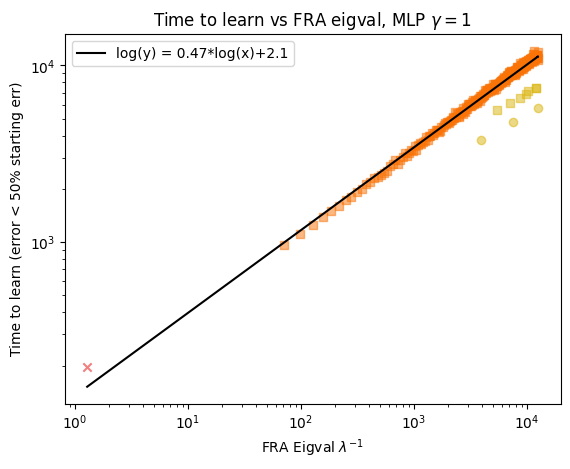

In [47]:
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys[-1]), axis=-1)
breakpoints_std = nanvar(torch.as_tensor(timekeys[-1]), axis=-1)
trainindex = 290

xaxis = (fra_eigvals[locs.long()][:trainindex].cpu())**(-1.)
ys = ensure_torch(breakpoints_means)[:trainindex]
slope, intercept = get_log_log_linear_fit(xaxis, ys)

plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()][:trainindex].cpu(), ys.cpu(), targets[:trainindex],
                                scale='log', breakpoint="(error < 50% starting err)", alpha=0.5, errorbar=False)
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.ylabel("Time to learn (error < 50% starting err)")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={GAMMA}$")
plt.show()

In [48]:
print(locs)

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  21.,  20.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         97.,  96.,  98., 100.,  99., 101., 103., 102., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 138., 137., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [55]:
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys[-1]), axis=-1)
breakpoints_std = nanvar(torch.as_tensor(timekeys[-1]), axis=-1, correction=0)
trainindex = 290



xaxis = (fra_eigvals[locs.long()][:trainindex].cpu())**(-1.)
ys = ensure_torch(breakpoints_means)[:trainindex]
yerr = ensure_torch(breakpoints_std)[:trainindex]
slope, intercept = get_log_log_linear_fit(xaxis, ys)

plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()][:trainindex].cpu(), ys.cpu(), targets[:trainindex],
                                scale='log', breakpoint="(error < 50% starting err)", alpha=0.5, errorbar=yerr)
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.ylabel("Time to learn (error < 50% starting err)")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={GAMMA}$")
plt.show()

<class 'str'>


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [51]:
yerr[58]

tensor(nan)